# Titanic Tutorial
### Solving Date: Jan 8th, 2024
#### Written by: [Jehwan Kim](https://github.com/kreimben)
#### Followed Materials:
* https://www.kaggle.com/code/gunesevitan/titanic-advanced-feature-engineering-tutorial?scriptVersionId=27280410

# 이 노트는 위의 링크를 따라하는 것(기존에 하지 않았던것 살펴보기, 다른 사람들은 어떤 시각으로 데이터를 해석했는지 접근 방식 얻기) + 추가적인 아이디어로 구성 돼있습니다.

In [1]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

warnings.filterwarnings('ignore')

SEED = 42  # preset for random seed.

%matplotlib inline

In [2]:
def concat_df(train_data, test_data):
    # Returns a concatenated df of training and test set
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)


def divide_df(all_data):
    # Returns divided dfs of training and test set
    return all_data.loc[:890], all_data.loc[891:].drop(['Survived'], axis=1)


df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

df_all = concat_df(df_train, df_test)

df_train.name = 'Training Set'
df_test.name = 'Test Set'
df_all.name = 'All Set'

dfs = [df_train, df_test]

# EDA

In [3]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1046 non-null   float64
 1   Cabin        295 non-null    object 
 2   Embarked     1307 non-null   object 
 3   Fare         1308 non-null   float64
 4   Name         1309 non-null   object 
 5   Parch        1309 non-null   int64  
 6   PassengerId  1309 non-null   int64  
 7   Pclass       1309 non-null   int64  
 8   Sex          1309 non-null   object 
 9   SibSp        1309 non-null   int64  
 10  Survived     891 non-null    float64
 11  Ticket       1309 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [4]:
df_train.sample(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
666,667,0,2,"Butler, Mr. Reginald Fenton",male,25.0,0,0,234686,13.0000,NaN,S
822,823,0,1,"Reuchlin, Jonkheer. John George",male,38.0,0,0,19972,0.0000,NaN,S
218,219,1,1,"Bazzani, Miss. Albina",female,32.0,0,0,11813,76.2917,D15,C


## missing values

### Age

In [5]:
def display_missing(df):
    for col in df.columns.tolist():
        print('{} column missing values: {}'.format(col, df[col].isnull().sum()))
    print('\n')


for df in dfs:
    print('{}'.format(df.name))
    display_missing(df)

Training Set
PassengerId column missing values: 0
Survived column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 177
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 0
Cabin column missing values: 687
Embarked column missing values: 2


Test Set
PassengerId column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 86
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 1
Cabin column missing values: 327
Embarked column missing values: 0


In [6]:
# 이 코드를 통해 corr를 이용하면 데이터 처리 전에 features 간의 상관관계를 먼저 알 수 있다는것을 알았다.
df_all_corr = df_all.corr(numeric_only=True).abs().unstack().sort_values(ascending=False).reset_index()
df_all_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_all_corr[df_all_corr['Feature 1'] == 'Pclass']

,Feature 1,Feature 2,Correlation Coefficient
3,Pclass,Pclass,1.000000
8,Pclass,Fare,0.558629
10,Pclass,Age,0.408106
14,Pclass,Survived,0.338481
31,Pclass,SibSp,0.060832
35,Pclass,PassengerId,0.038354
44,Pclass,Parch,0.018322


`Age` 값을 그냥 median, mean으로 채울수도 좋은 선택은 아니라고 생각한다.
그래서 그들간의 상관관계를 파악해보았다. 

In [7]:
age_by_pclass_sex = df_all[['Sex', 'Pclass', 'Age']].groupby(['Sex', 'Pclass']).median()['Age']

# Filling the missing values in Age with the medians of Sex and Pclass groups
# df_all['Age'] = df_all[['Sex', 'Pclass', 'Age']].groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median())) # 코드 작동 안함
df_all.Age = df_all[['Sex', 'Pclass', 'Age']].groupby(['Sex', 'Pclass']).transform(lambda x: x.fillna(x.median()))

age_by_pclass_sex

Sex     Pclass
female  1         36.0
        2         28.0
        3         22.0
male    1         42.0
        2         29.5
        3         25.0
Name: Age, dtype: float64

In [8]:
df_all[['Sex', 'Pclass', 'Age']].groupby(['Sex', 'Pclass']).head(1000)

,Sex,Pclass,Age
0,male,3,22.0
1,female,1,38.0
2,female,3,26.0
3,female,1,35.0
4,male,3,35.0
...,...,...,...
1304,male,3,25.0
1305,female,1,39.0
1306,male,3,38.5
1307,male,3,25.0


In [9]:
df_all.Age.isna().sum()

0

### Embarked

결측치가 2개 밖에 없어서 그냥 최빈값 넣어도 괜찮을것 같지만, 저자는 다른 접근을 했다.

In [10]:
df_all[df_all.Embarked.isna()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
61,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,62,1,female,0,1.0,113572
829,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,830,1,female,0,1.0,113572


어디서 탑승했는지 모르는 2명은 사실 같은 일행이였다. 좌석번호도 같고, 생존여부, 티켓번호도 같다.
여기서 저자는 위키피디아를 검색해 실제로 이 둘이 어디서 탑승 했는지 찾아냈고, S였다고 한다.

In [11]:
df_all.Embarked = df_all.Embarked.fillna('S')

In [12]:
df_all.Embarked.isna().sum()

0

### Fare

요금 항목은 딱 1개의 결측치만 있다. 어떤 연관관계가 있을지 살펴보자.

In [13]:
df_all[df_all.Fare.isna()]

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
1043,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,1044,3,male,0,NaN,3701


이 사람은 남성, 동승한 가족은 없고, 3등석에 탑승했다. 그래서 비슷한 조건의 티켓 가격을 고려해 보도록 하자.

In [14]:
df_family = df_all.copy()

df_family['FamilySize'] = df_family['Parch'] + df_family['SibSp'] + 1
df_family.drop(['Parch', 'SibSp'], axis=1, inplace=True)

df_family.sample(5)

,Age,Cabin,Embarked,Fare,Name,PassengerId,Pclass,Sex,Survived,Ticket,FamilySize
1048,23.0,NaN,S,7.8542,"Lundin, Miss. Olga Elida",1049,3,female,NaN,347469,1
1113,22.0,F33,S,10.5000,"Cook, Mrs. (Selena Rogers)",1114,2,female,NaN,W./C. 14266,1
394,24.0,G6,S,16.7000,"Sandstrom, Mrs. Hjalmar (Agnes Charlotta Bengt...",395,3,female,1.0,PP 9549,3
417,18.0,NaN,S,13.0000,"Silven, Miss. Lyyli Karoliina",418,2,female,1.0,250652,3
144,18.0,NaN,S,11.5000,"Andrew, Mr. Edgardo Samuel",145,2,male,0.0,231945,1


In [15]:
df_fare = df_family[['Pclass', 'Fare', 'Sex', 'FamilySize']].groupby(['Pclass', 'Sex', 'FamilySize']).median()
df_fare.head(10000)

Fare
Pclass Sex    FamilySize           
1      female 1            84.82915
              2            76.72920
              3            79.65000
              4           120.00000
              5           262.37500
              6           263.00000
       male   1            29.85000
              2            63.35830
              3           102.19165
              4           135.77500
              5           262.37500
              6           263.00000
2      female 1            13.00000
              2            26.00000
              3            26.25000
              4            39.00000
              5            23.00000
              6            18.75000
       male   1            13.00000
              2            26.00000
              3            30.25000
              4            39.00000
3      female 1             7.77500
              2            14.45420
              3            15.74170
              4            19.25830
              5            25.46670
              6            27.90000
              7            31.27500
              8            46.90000
              11           69.55000
       male   1             7.88750
              2            14.45420
              3            15.24580
              4            20.57500
              5            23.74585
              6            29.12500
              7            31.38750
              8            46.90000
              11           69.55000

위의 표를 보면, 3등석에 탑승한 남성이고, 가족이 없는 사람의 티켓 가격은 7.88750이다.
이 값을 넣어주자.

In [16]:
df_all.Fare = df_all.Fare.fillna(7.88750)
df_all.Fare.isna().sum()

0

### Cabin

![](https://vignette.wikia.nocookie.net/titanic/images/f/f9/Titanic_side_plan.png/revision/latest?cb=20180322183733)

위 이미지를 보면 타이타닉의 각각 선실의 위치를 알 수 있다. `Cabin`을 완전히 버리는 방법도 있지만, 이는 좋은 선택이 아닌데 왜냐하면 선실마다 생존율이 다르기 때문이다.

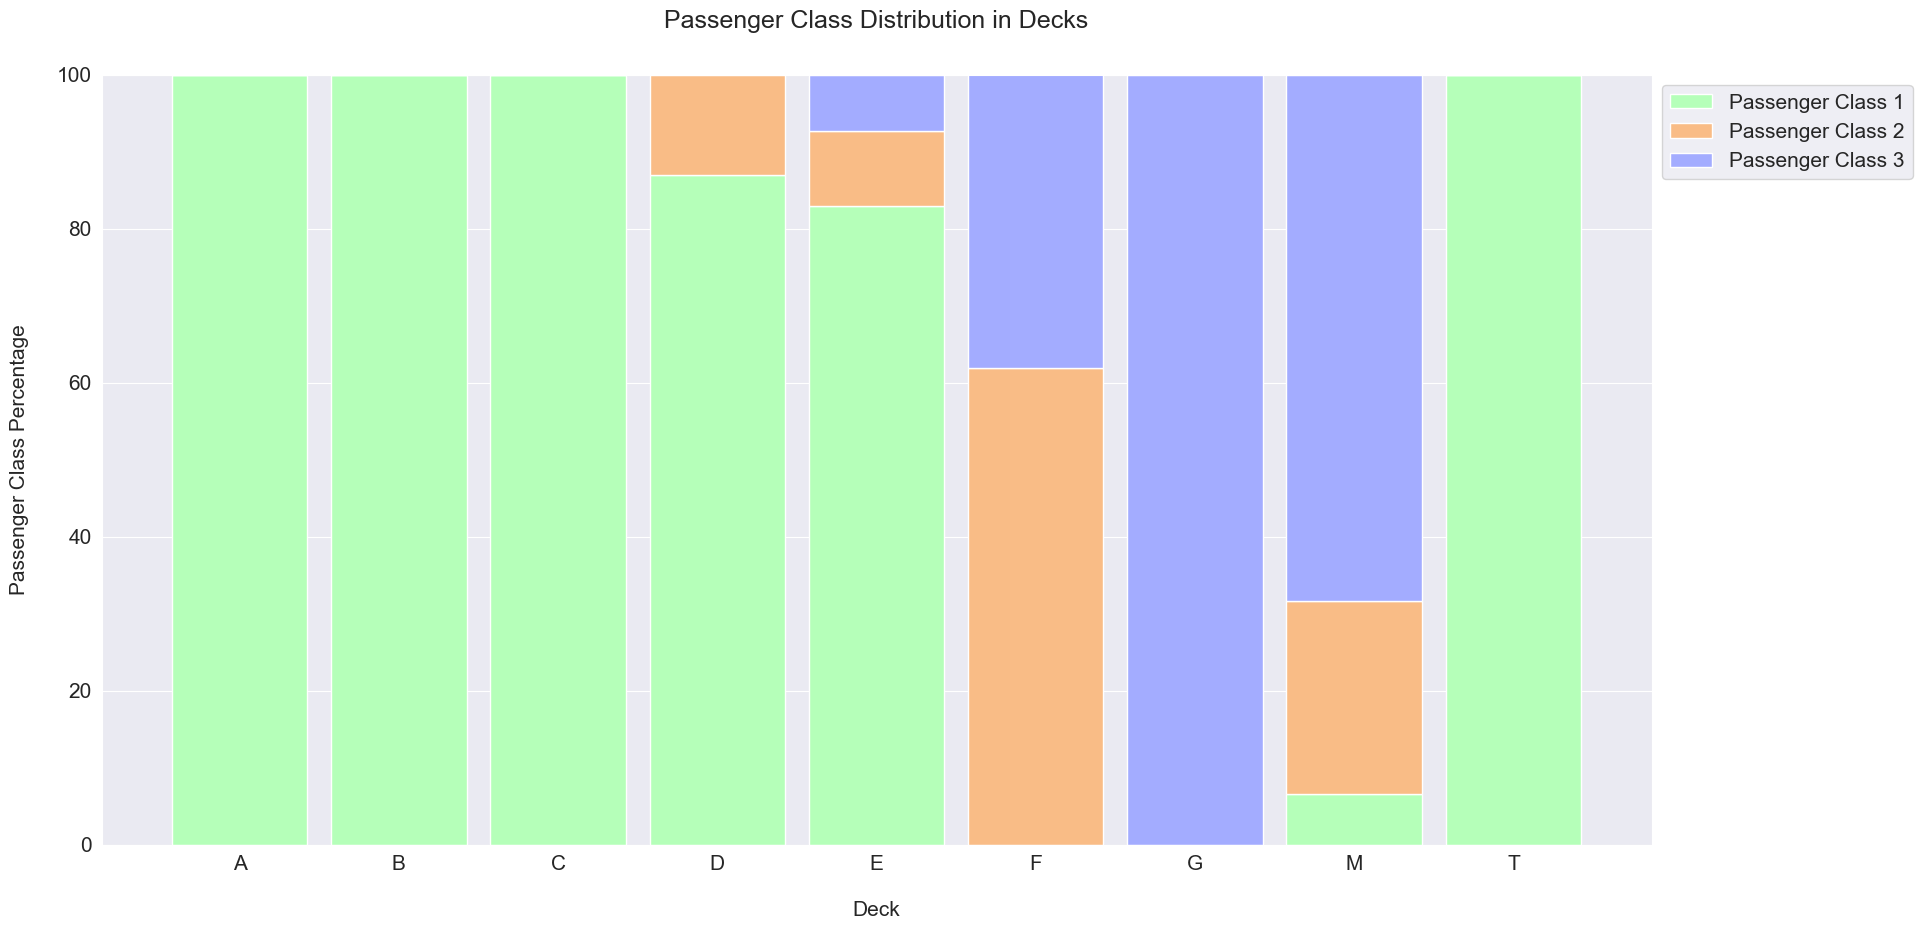

Deck     A   B   C   D      E         F     G   M            T
Pclass   1   1   1   1  2   1  2  3   2  3  3   1    2    3  1
Count   22  65  94  40  6  34  4  3  13  8  5  67  254  693  1

In [17]:
df_all['Deck'] = df_all.Cabin.apply(lambda x: x[0] if pd.notnull(x) else 'M')  # `M` stands for Missing

df_all_decks = df_all.groupby(['Deck', 'Pclass']).count().drop(columns=['Survived', 'Sex', 'Age', 'SibSp', 'Parch', 
                                                                        'Fare', 'Embarked', 'Cabin', 'PassengerId', 'Ticket']).rename(columns={'Name': 'Count'}).transpose()


def get_pclass_dist(df):
    # Creating a dictionary for every passenger class count in every deck
    deck_counts = {'A': {}, 'B': {}, 'C': {}, 'D': {}, 'E': {}, 'F': {}, 'G': {}, 'M': {}, 'T': {}}
    decks = df.columns.levels[0]    
    
    for deck in decks:
        for pclass in range(1, 4):
            try:
                count = df[deck][pclass][0]
                deck_counts[deck][pclass] = count 
            except KeyError:
                deck_counts[deck][pclass] = 0
                
    df_decks = pd.DataFrame(deck_counts)    
    deck_percentages = {}

    # Creating a dictionary for every passenger class percentage in every deck
    for col in df_decks.columns:
        deck_percentages[col] = [(count / df_decks[col].sum()) * 100 for count in df_decks[col]]
        
    return deck_counts, deck_percentages

def display_pclass_dist(percentages):
    df_percentages = pd.DataFrame(percentages).transpose()
    deck_names = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'M', 'T')
    bar_count = np.arange(len(deck_names))  
    bar_width = 0.85
    
    pclass1 = df_percentages[0]
    pclass2 = df_percentages[1]
    pclass3 = df_percentages[2]
    
    plt.figure(figsize=(20, 10))
    plt.bar(bar_count, pclass1, color='#b5ffb9', edgecolor='white', width=bar_width, label='Passenger Class 1')
    plt.bar(bar_count, pclass2, bottom=pclass1, color='#f9bc86', edgecolor='white', width=bar_width, label='Passenger Class 2')
    plt.bar(bar_count, pclass3, bottom=pclass1 + pclass2, color='#a3acff', edgecolor='white', width=bar_width, label='Passenger Class 3')

    plt.xlabel('Deck', size=15, labelpad=20)
    plt.ylabel('Passenger Class Percentage', size=15, labelpad=20)
    plt.xticks(bar_count, deck_names)    
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 15})
    plt.title('Passenger Class Distribution in Decks', size=18, y=1.05)   
    
    plt.show()    

all_deck_count, all_deck_per = get_pclass_dist(df_all_decks)
display_pclass_dist(all_deck_per)

df_all_decks

* A, B, C 덱은 1등실만 있다. 
* D, E는 모든 등급이 다 있다.
* F, G는 2, 3등실만 있다.
* A부터 G까지, 계단까지의 거리가 증가하는데, 이는 생존에 영향을 미칠 수 있다.

* A, B, C덱은 1등실만 있다.
* D덱에 1등실이 87%나 차지한다. 그리고 2등실은 13%다.
* E덱에는 1등실이 83%, 2등실이 10%, 3등실이 7%다.
* F덱에는 2등실이 62%, 3등실이 38%다.
* G덱은 3등실만 있다.
* T덱에 탑승한 사람은 1명이고 1등실이다. T덱의 승객은 A덱의 승객과 가장 닮았기 때문에 A덱에 포함시킨다.
* M으로 표시된 승객은 선실이 없는 승객이다. 이 승객들의 선실을 찾는것은 불가능하다고 생각하기 때문에, M을 하나의 덱으로 취급한다.

In [18]:
# Passenger in the T deck is changed to A
idx = df_all[df_all['Deck'] == 'T'].index
df_all.loc[idx, 'Deck'] = 'A'

In [19]:
# df_all[ df_all['Deck'] == 'T' ]

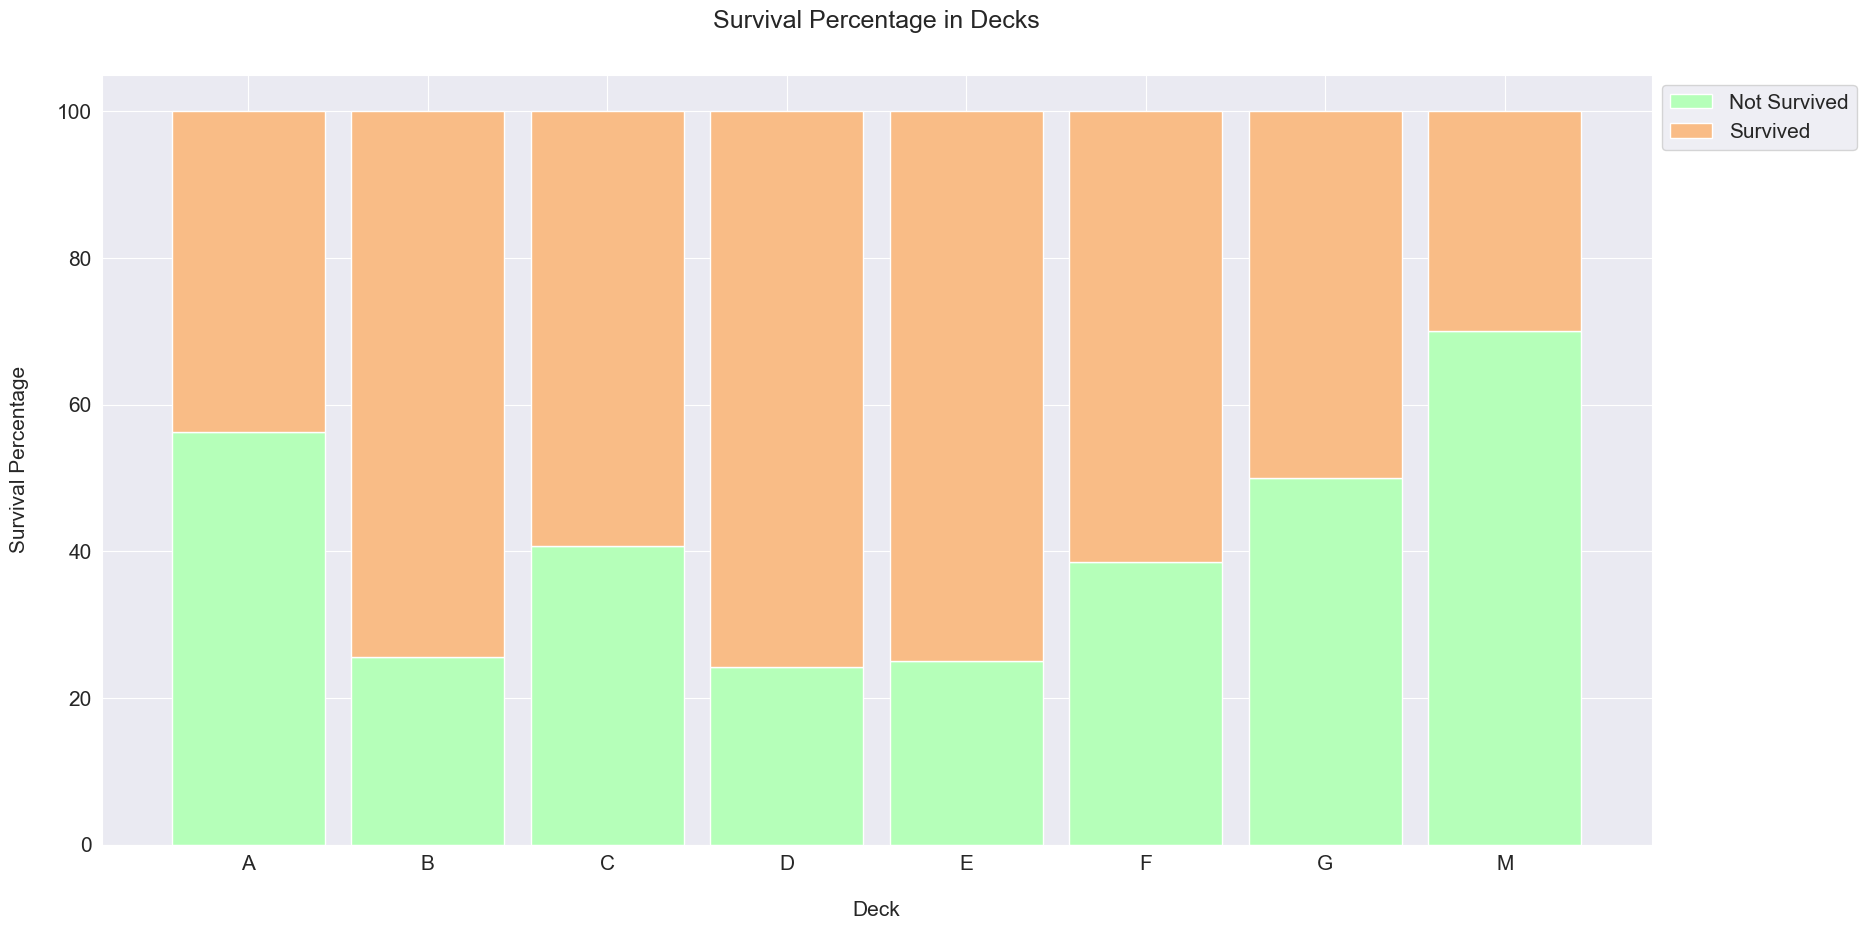

In [20]:
df_all_decks_survived = df_all.groupby(['Deck', 'Survived']).count().drop(columns=['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 
                                                                                   'Embarked', 'Pclass', 'Cabin', 'PassengerId', 'Ticket']).rename(columns={'Name':'Count'}).transpose()

def get_survived_dist(df):
    # Creating a dictionary for every survival count in every deck
    surv_counts = {'A':{}, 'B':{}, 'C':{}, 'D':{}, 'E':{}, 'F':{}, 'G':{}, 'M':{}}
    decks = df.columns.levels[0]    

    for deck in decks:
        for survive in range(0, 2):
            surv_counts[deck][survive] = df[deck][survive][0]
            
    df_surv = pd.DataFrame(surv_counts)
    surv_percentages = {}

    for col in df_surv.columns:
        surv_percentages[col] = [(count / df_surv[col].sum()) * 100 for count in df_surv[col]]
        
    return surv_counts, surv_percentages

def display_surv_dist(percentages):
    df_survived_percentages = pd.DataFrame(percentages).transpose()
    deck_names = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'M')
    bar_count = np.arange(len(deck_names))  
    bar_width = 0.85    

    not_survived = df_survived_percentages[0]
    survived = df_survived_percentages[1]
    
    plt.figure(figsize=(20, 10))
    plt.bar(bar_count, not_survived, color='#b5ffb9', edgecolor='white', width=bar_width, label="Not Survived")
    plt.bar(bar_count, survived, bottom=not_survived, color='#f9bc86', edgecolor='white', width=bar_width, label="Survived")
 
    plt.xlabel('Deck', size=15, labelpad=20)
    plt.ylabel('Survival Percentage', size=15, labelpad=20)
    plt.xticks(bar_count, deck_names)    
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 15})
    plt.title('Survival Percentage in Decks', size=18, y=1.05)
    
    plt.show()

all_surv_count, all_surv_per = get_survived_dist(df_all_decks_survived)
display_surv_dist(all_surv_per)

추정해보건데, 모든 덱은 다른 생존률을 보여주고 있으며 그 정보는 절대로 버려질 수 없다. B, C, D, E는 생존율이 가장 높다. 이 덱들은 1등석 승객들이 가장많이 있다. M은 생존률이 가장 낮은데 대부분 2, 3등실 탑승객이다. 결론을 내리자면, 1등석 승객들이 탑승한 선실은 2, 3등석 승객들이 탑승한 선실보다 생존율이 높다. M(결측치)는 생존율이 가장 낮은데 이는 희생자들의 선실 데이터를 찾지 못했기 때문이라고 생각한다. 그래서 나는 이 그룹을 M으로 라벨링 하는것이 결측치를 처리하는 합리적인 방법이라고 생각한다. 이것은 공유된 특성을 가진 독특한 그룹이다. 덱 피쳐는 현재 고차원이기 때문에, 그들의 유사성에 따라 몇몇 값들이 함께 그룹화 된다. 

* A, B, C 덱들은 1등석 승객들만 탑승했기 때문에 ABC로 라벨링 했다.
* D, E 덱들은 비슷한 승객들이 탑승했고, 생존율도 비슷하기 때문에 DE로 라벨링 했다.
* F, G 덱들은 비슷한 승객들이 탑승했고, 생존율도 비슷하기 때문에 FG로 라벨링 했다.
* M 덱은 다른 덱들과 그룹화 될 필요가 없다. 왜냐하면 다른 덱들과 매우 다르고, 생존율도 가장 낮기 때문이다.

In [21]:
df_all['Deck'] = df_all['Deck'].replace(['A', 'B', 'C'], 'ABC')
df_all['Deck'] = df_all['Deck'].replace(['D', 'E'], 'DE')
df_all['Deck'] = df_all['Deck'].replace(['F', 'G'], 'FG')

df_all['Deck'].value_counts()

Deck
M      1014
ABC     182
DE       87
FG       26
Name: count, dtype: int64

In [22]:
# Dropping the Cabin feature
df_all.drop(['Cabin'], inplace=True, axis=1)

df_train, df_test = divide_df(df_all)
dfs = [df_train, df_test]

In [23]:
# There are no more missing values in data!
df_all.isna().sum()

Age              0
Embarked         0
Fare             0
Name             0
Parch            0
PassengerId      0
Pclass           0
Sex              0
SibSp            0
Survived       418
Ticket           0
Deck             0
dtype: int64

In [24]:
survived = df_train['Survived'].value_counts()[1]
not_survived = df_train['Survived'].value_counts()[0]
survived_per = survived / df_train.shape[0] * 100
not_survived_per = not_survived / df_train.shape[0] * 100

print('{} of {} passengers survived and it is the {:.2f}% of the training set.'.format(survived, df_train.shape[0], survived_per))
print('{} of {} passengers didnt survive and it is the {:.2f}% of the training set.'.format(not_survived, df_train.shape[0], not_survived_per))

342 of 891 passengers survived and it is the 38.38% of the training set.
549 of 891 passengers didnt survive and it is the 61.62% of the training set.


### Correlation Between Features

In [25]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1309 non-null   float64
 1   Embarked     1309 non-null   object 
 2   Fare         1309 non-null   float64
 3   Name         1309 non-null   object 
 4   Parch        1309 non-null   int64  
 5   PassengerId  1309 non-null   int64  
 6   Pclass       1309 non-null   int64  
 7   Sex          1309 non-null   object 
 8   SibSp        1309 non-null   int64  
 9   Survived     891 non-null    float64
 10  Ticket       1309 non-null   object 
 11  Deck         1309 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [26]:
df_train_corr = df_train.drop(['PassengerId'], axis=1).corr(numeric_only=True).abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_train_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_train_corr.drop(df_train_corr.iloc[1::2].index, inplace=True)
df_train_corr_nd = df_train_corr.drop(df_train_corr[df_train_corr['Correlation Coefficient'] == 1.0].index)

df_test_corr = df_test.corr(numeric_only=True).abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_test_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_test_corr.drop(df_test_corr.iloc[1::2].index, inplace=True)
df_test_corr_nd = df_test_corr.drop(df_test_corr[df_test_corr['Correlation Coefficient'] == 1.0].index)

In [27]:
# Training set high correlations
corr = df_train_corr_nd['Correlation Coefficient'] > 0.1
df_train_corr_nd[corr]

,Feature 1,Feature 2,Correlation Coefficient
6,Fare,Pclass,0.549500
8,Age,Pclass,0.417667
10,Parch,SibSp,0.414838
12,Pclass,Survived,0.338481
14,Fare,Survived,0.257307
16,Age,SibSp,0.249747
18,Parch,Fare,0.216225
20,Parch,Age,0.176733
22,SibSp,Fare,0.159651
24,Age,Fare,0.124061


In [28]:
# Test set high correlations
corr = df_test_corr_nd['Correlation Coefficient'] > 0.1
df_test_corr_nd[corr]

,Feature 1,Feature 2,Correlation Coefficient
6,Pclass,Fare,0.577488
8,Age,Pclass,0.526789
10,Age,Fare,0.345351
12,SibSp,Parch,0.306895
14,Parch,Fare,0.230410
16,Fare,SibSp,0.172031


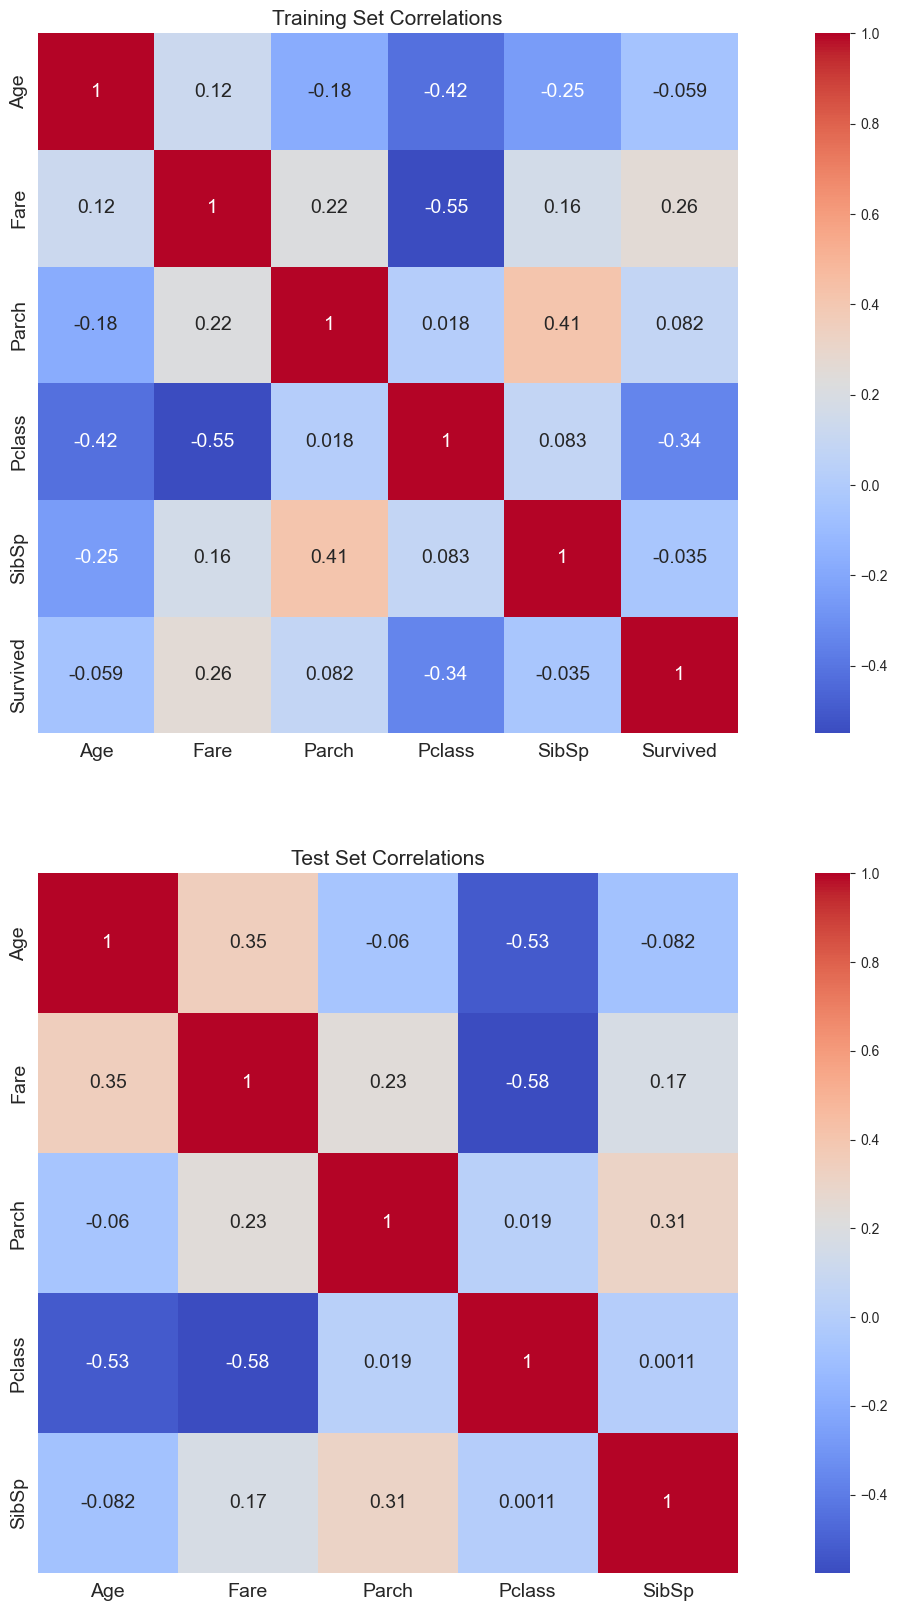

In [29]:
fig, axs = plt.subplots(nrows=2, figsize=(20, 20))

sns.heatmap(df_train.drop(['PassengerId'], axis=1).corr(numeric_only=True), ax=axs[0], annot=True, square=True, cmap='coolwarm', annot_kws={'size': 14})
sns.heatmap(df_test.drop(['PassengerId'], axis=1).corr(numeric_only=True), ax=axs[1], annot=True, square=True, cmap='coolwarm', annot_kws={'size': 14})

for i in range(2):    
    axs[i].tick_params(axis='x', labelsize=14)
    axs[i].tick_params(axis='y', labelsize=14)
    
axs[0].set_title('Training Set Correlations', size=15)
axs[1].set_title('Test Set Correlations', size=15)

plt.show()

### Continuous Features

`Age`, `Fare`는 연속적인 값이다. 따라서 적절히 나눠줘야 한다.

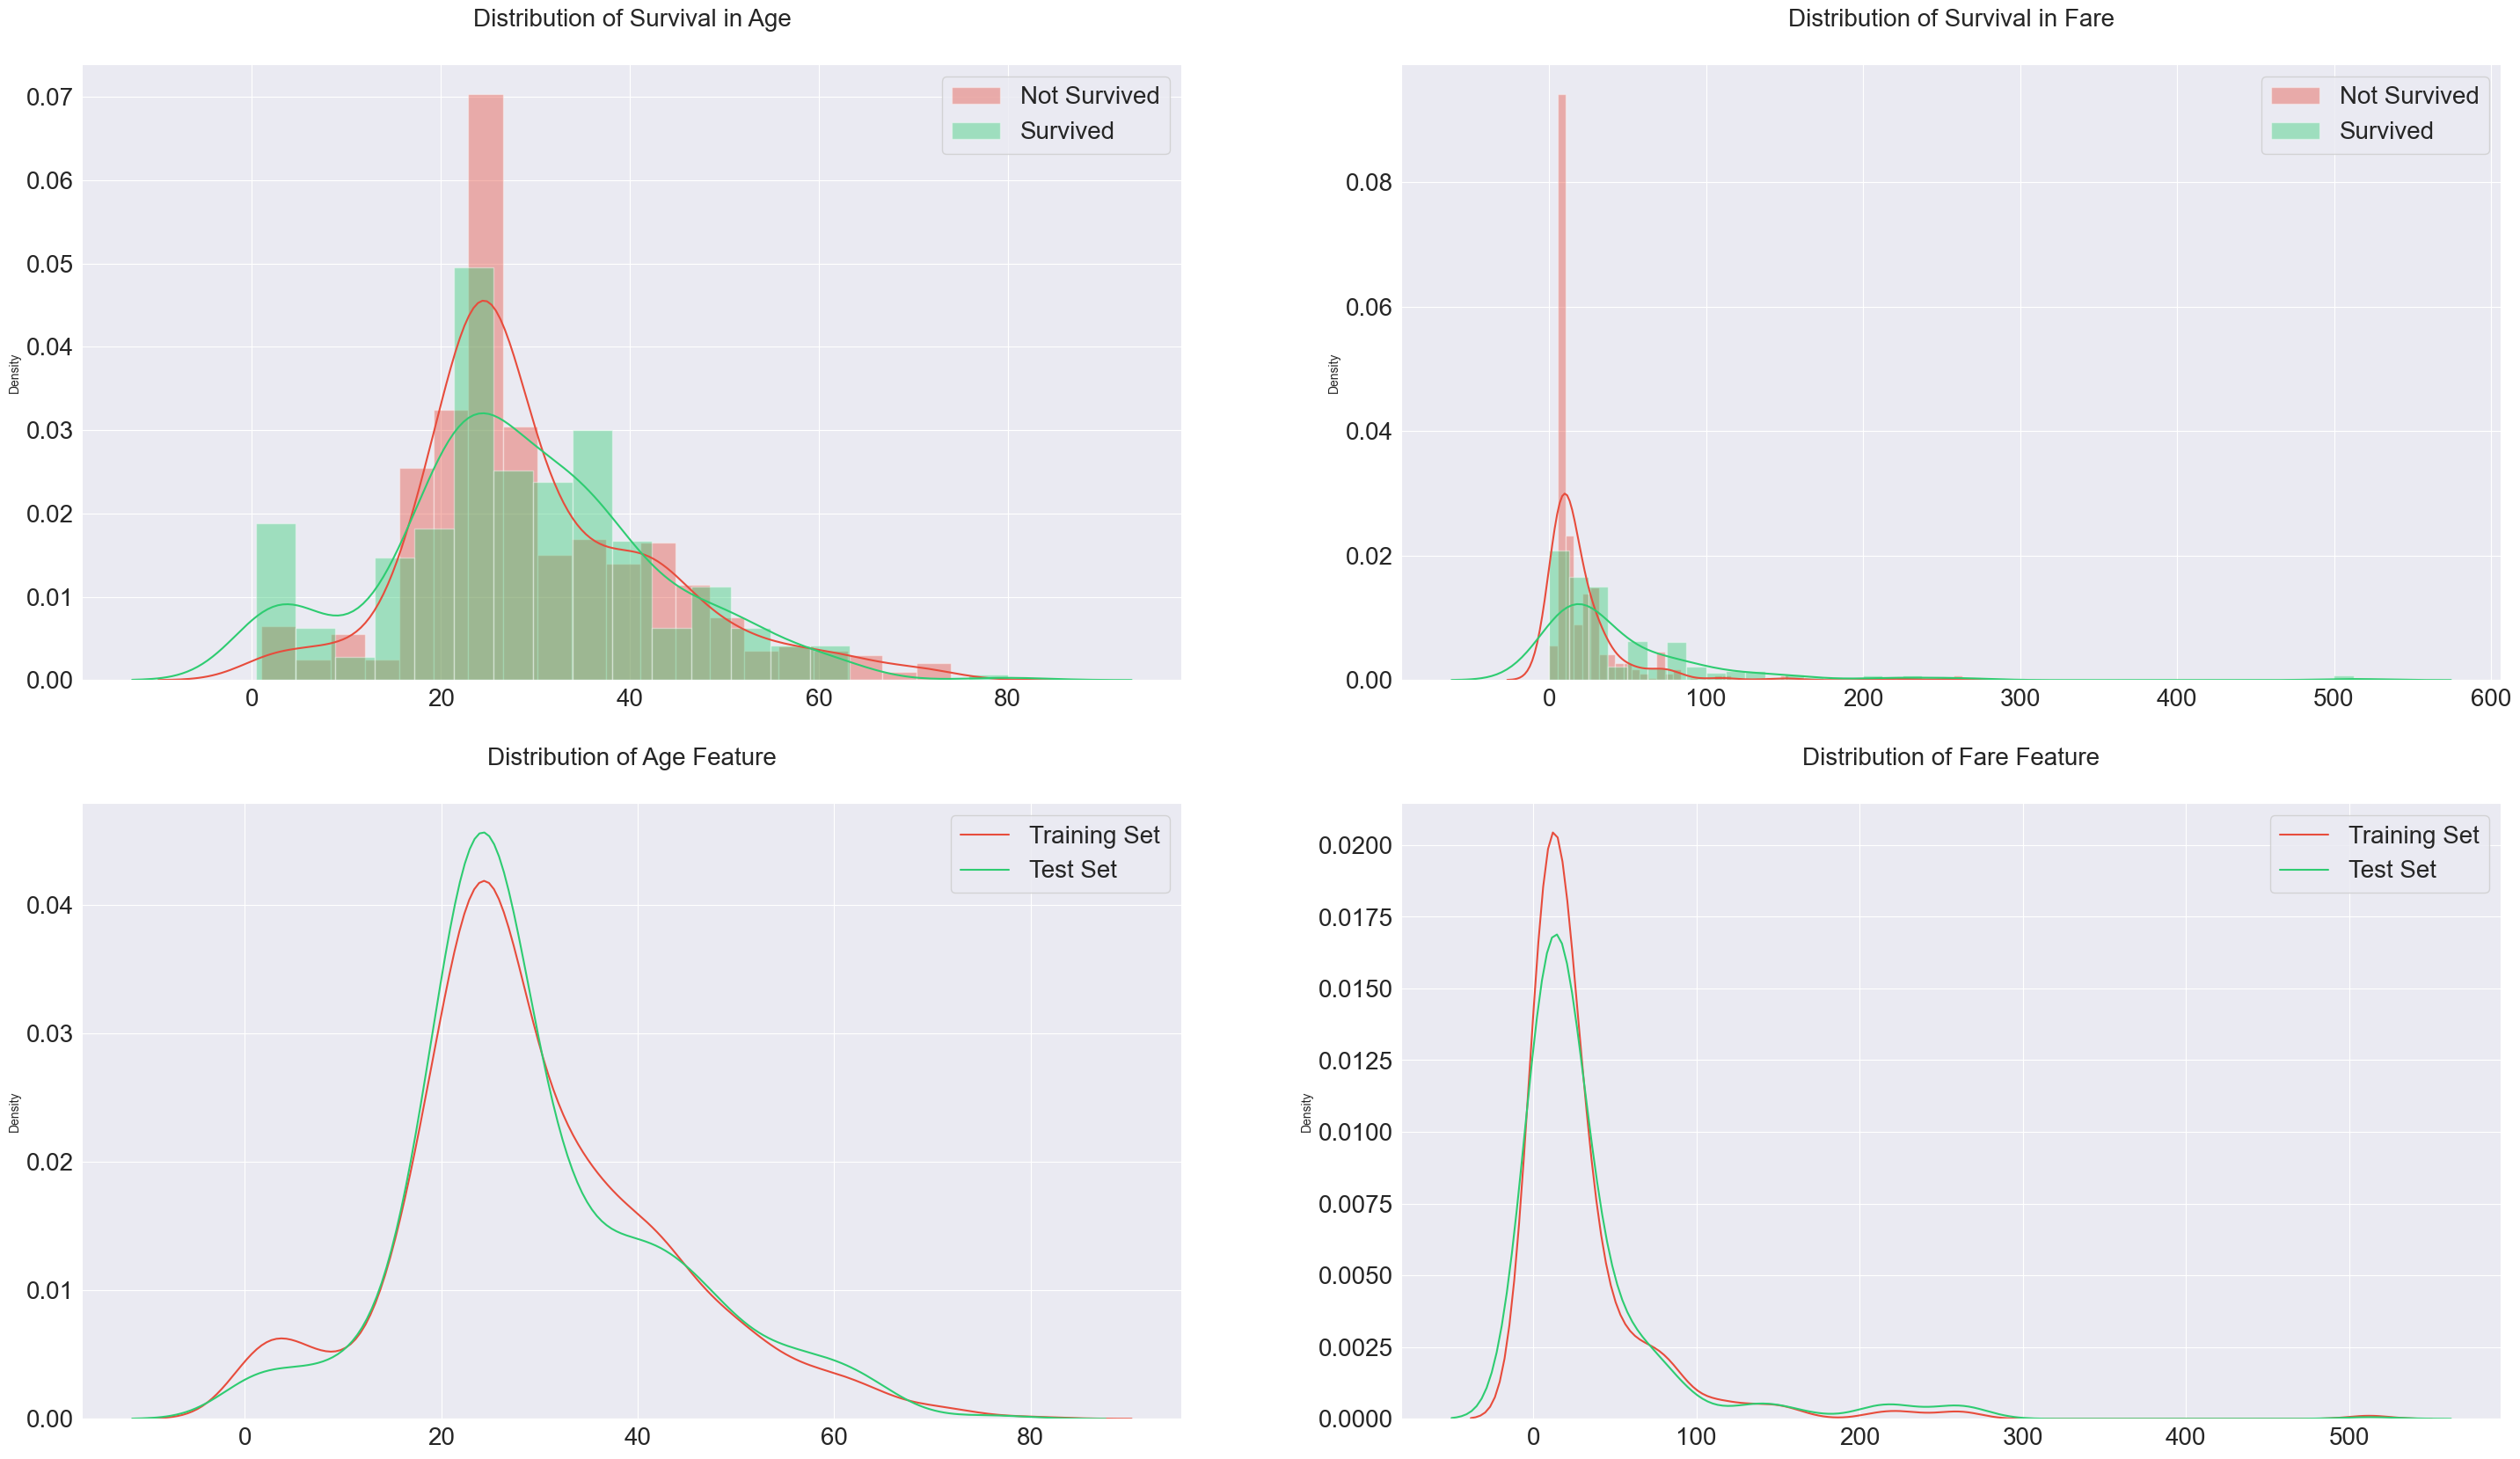

In [30]:
cont_features = ['Age', 'Fare']
surv = df_train['Survived'] == 1

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(20, 20))
plt.subplots_adjust(right=1.5)

for i, feature in enumerate(cont_features):    
    # Distribution of survival in feature
    sns.distplot(df_train[~surv][feature], label='Not Survived', hist=True, color='#e74c3c', ax=axs[0][i])
    sns.distplot(df_train[surv][feature], label='Survived', hist=True, color='#2ecc71', ax=axs[0][i])
    
    # Distribution of feature in dataset
    sns.distplot(df_train[feature], label='Training Set', hist=False, color='#e74c3c', ax=axs[1][i])
    sns.distplot(df_test[feature], label='Test Set', hist=False, color='#2ecc71', ax=axs[1][i])
    
    axs[0][i].set_xlabel('')
    axs[1][i].set_xlabel('')
    
    for j in range(2):        
        axs[i][j].tick_params(axis='x', labelsize=20)
        axs[i][j].tick_params(axis='y', labelsize=20)
    
    axs[0][i].legend(loc='upper right', prop={'size': 20})
    axs[1][i].legend(loc='upper right', prop={'size': 20})
    axs[0][i].set_title('Distribution of Survival in {}'.format(feature), size=20, y=1.05)

axs[1][0].set_title('Distribution of {} Feature'.format('Age'), size=20, y=1.05)
axs[1][1].set_title('Distribution of {} Feature'.format('Fare'), size=20, y=1.05)
        
plt.show()

나이와 요금 둘다 연속적인 피쳐들이고 쪼개기 좋은 포인트들이 있다. 하지만 두 피쳐 모두 트레이닝 셋에선 더 많은 스파이크와 범프를 가지고 있지만, 테스트 셋에선 더 부드러운 분포를 가지고 있다. 
이러한 이유로 모델은 테스트 셋에 일반화 할 수 없을 것이다.

* 나이 분포 피쳐들은 분명하게 15살 이하의 어린이들이 다른 나이 그룹들보다 더 높은 생존율을 가지고 있다는 것을 보여준다. 요금 분포 피쳐들은 생존율이 분포의 꼬리에 더 높다. 
* 이 분포는 극단적으로 큰 아웃라이어들 때문에 양의 왜도를 가지고 있다. => 이전 학습에서도 느꼈던 부분...

### Categorical Features

모든 범주형 피쳐들은 최소한 하나의 클래스가 높은 사망률을 가지고 있다. 이러한 클래스들은 승객이 생존자인지 희생자인지 예측하는데 매우 도움이 된다. 가장 좋은 범주형 피쳐들은 Pclass와 Sex이다. 왜냐하면 가장 균질한 분포를 가지고 있기 때문이다.

* Southhampton에서 탑승한 승객들은 다른 항구보다 생존률이 낮다. Cerbourg에서 탑승한 승객은 절반 넘게 살았다. 이것은 Pclass와 관련이 있을 수 있다.
* Parch와 SibSp 피쳐들은 가족이 1명인 승객들이 더 높은 생존율을 가지고 있다는 것을 보여준다.

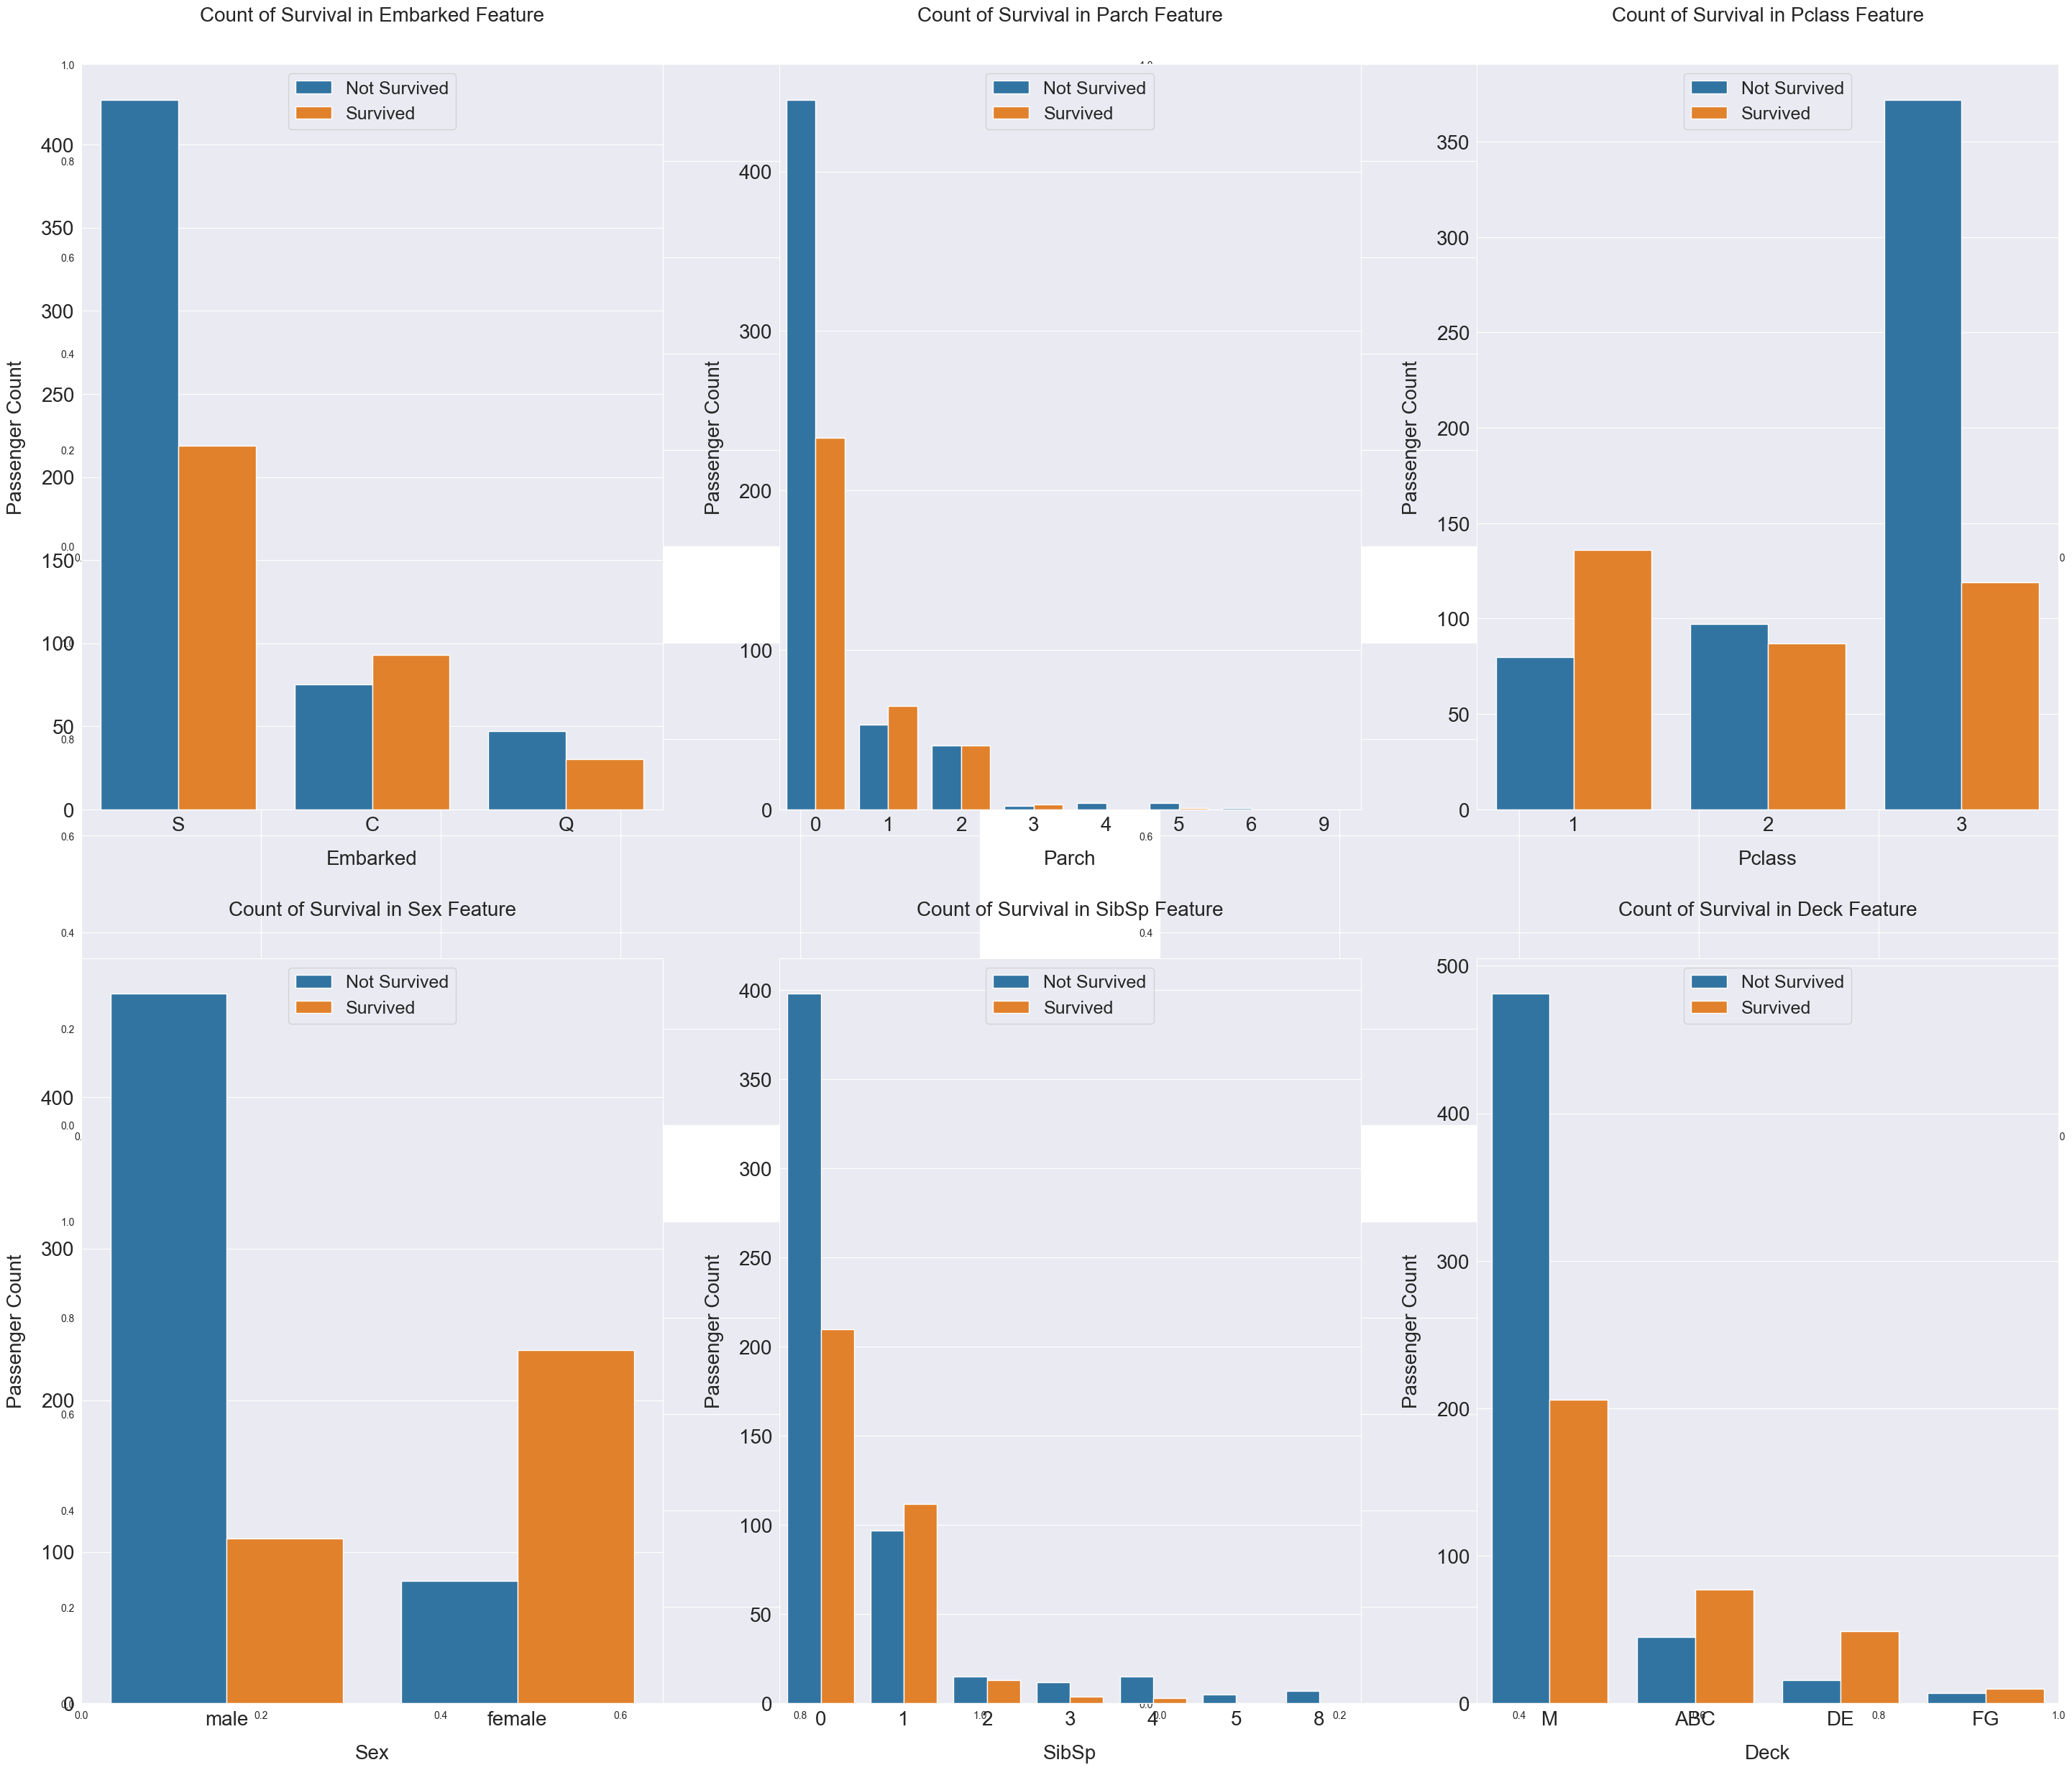

In [31]:
cat_features = ['Embarked', 'Parch', 'Pclass', 'Sex', 'SibSp', 'Deck']

fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(20, 20))
plt.subplots_adjust(right=1.5, top=1.25)

for i, feature in enumerate(cat_features, 1):    
    plt.subplot(2, 3, i)
    sns.countplot(x=feature, hue='Survived', data=df_all)#df_train)
    
    plt.xlabel('{}'.format(feature), size=20, labelpad=15)
    plt.ylabel('Passenger Count', size=20, labelpad=15)    
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    
    plt.legend(['Not Survived', 'Survived'], loc='upper center', prop={'size': 18})
    plt.title('Count of Survival in {} Feature'.format(feature), size=20, y=1.05)

In [32]:
df_all

,Age,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Deck
0,22.0,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,M
1,38.0,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,ABC
2,26.0,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,M
3,35.0,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,ABC
4,35.0,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,M
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,25.0,S,8.0500,"Spector, Mr. Woolf",0,1305,3,male,0,NaN,A.5. 3236,M
1305,39.0,C,108.9000,"Oliva y Ocana, Dona. Fermina",0,1306,1,female,0,NaN,PC 17758,ABC
1306,38.5,S,7.2500,"Saether, Mr. Simon Sivertsen",0,1307,3,male,0,NaN,SOTON/O.Q. 3101262,M
1307,25.0,S,8.0500,"Ware, Mr. Frederick",0,1308,3,male,0,NaN,359309,M


대부분의 피쳐들은 서로 연관돼 있다. 이 관계는 feature transformation과 feature interaction으로 새로운 피쳐들을 만드는데 사용 될 수 있다. 타겟 인코딩은 생존율과 높은 상관관계를 가지고 있기 때문에 매우 유용할 수 있다.

쪼개는 포인트들과 스파이크들은 연속된 피쳐들에서 보인다. 이것들은 결정 트리 모델로 쉽게 캡쳐 될 수 있지만, 선형 모델은 그것들을 찾을 수 없을 수도 있다.

카테고리형 피쳐들은 다른 생존률로써 매우 잘 구분되는 분포를 가지고 있다. 이런 피쳐들은 one-hot 암호화를 할 수 있다. 이런 피쳐들 중 몇몇은 새로운 피쳐를 만들기 위해 서로 결합될 수 있다. 

우리는 EDA파트에서 `Deck`이라는 새로운 피쳐를 만들거나 `Cabin` 피쳐를 버렸다.

In [33]:
df_all = concat_df(df_train, df_test)
df_all.head()

,Age,Deck,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,M,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,ABC,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,M,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,ABC,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,M,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


# Feature Engineering

요금 피쳐는 right skewed 됐고 맨 오른쪽으로 가면 생존률은 매우 높다. 13개의 quantile 기반의 bin들이 요금 피쳐에 사용됐다. 비록 bin들이 너무 많지만, 그들은 적절한 양의 정보를 제공한다. 그래프의 왼쪽에 있는 그룹들은 가장 낮은 생존율을 가지고 있고, 오른쪽에 있는 그룹들은 가장 높은 생존율을 가지고 있다. 이 높은 생존율은 분포 그래프에서는 보이지 않았다. 또한 중간에 있는 높은 생존율을 가진 이상한 그룹(15.742, 23.25]이 이 과정에서 포착됐다.

In [34]:
df_all.Fare.describe() # 다양한 정보를 참조하기 위해 describe()를 사용했다.

count    1309.000000
mean       33.276069
std        51.743645
min         0.000000
25%         7.895800
50%        14.454200
75%        31.275000
max       512.329200
Name: Fare, dtype: float64

In [35]:
# 왜 binning의 기준이 13이였을까?
df_all['Fare'] = pd.qcut(df_all['Fare'], 13)

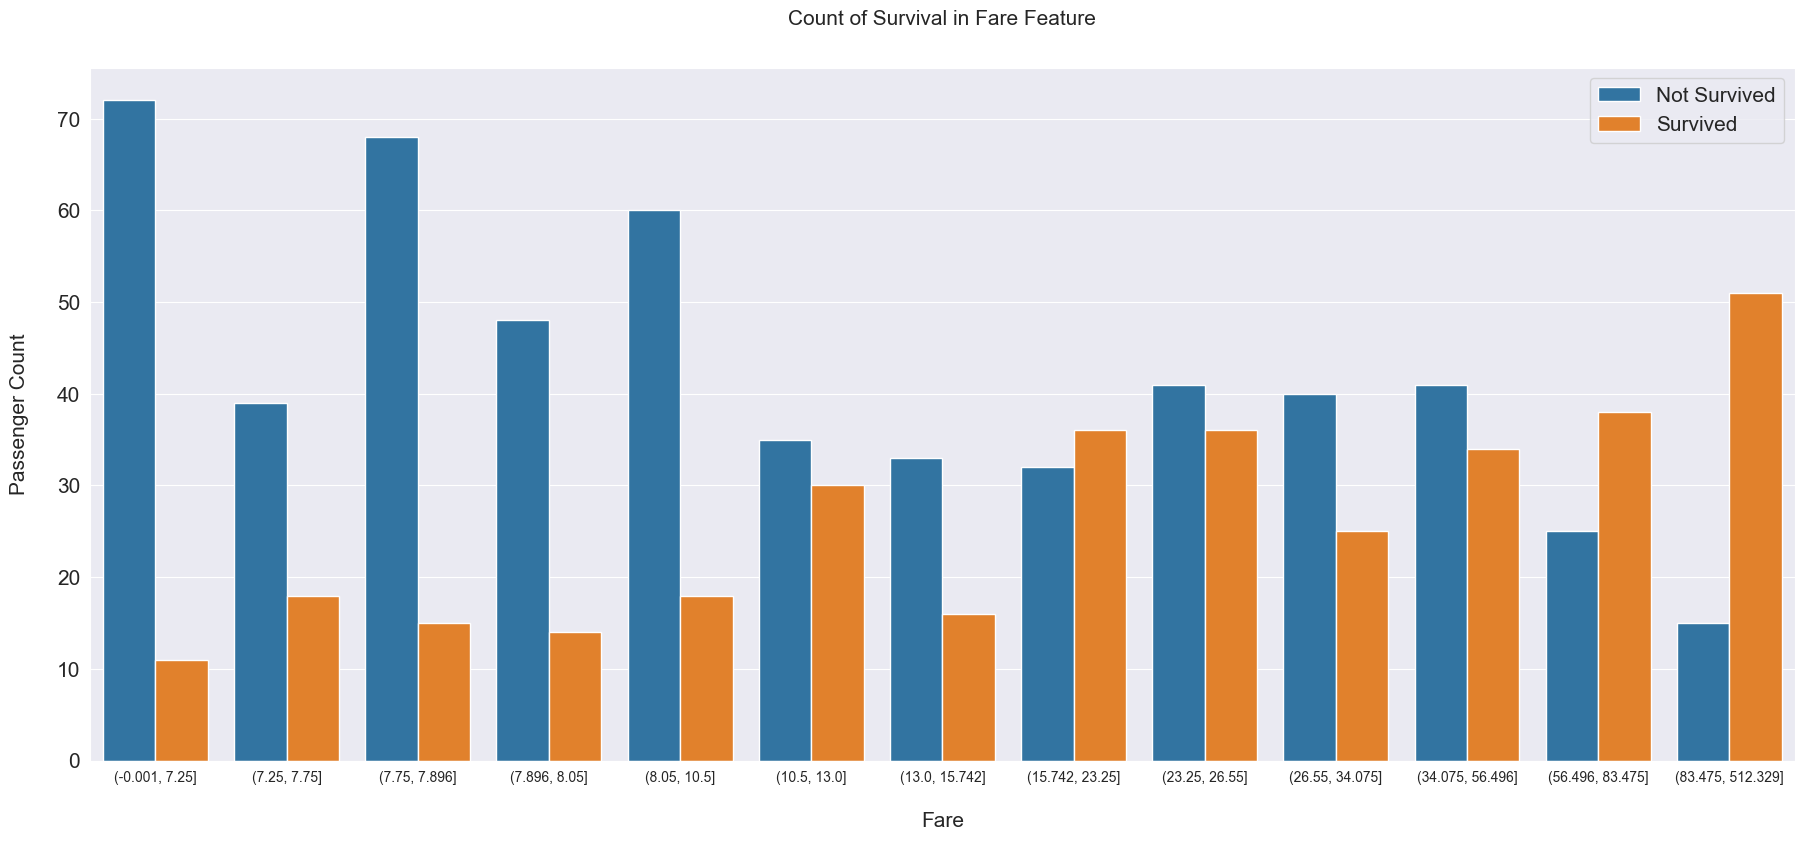

In [36]:
fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(x='Fare', hue='Survived', data=df_all)

plt.xlabel('Fare', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Count of Survival in {} Feature'.format('Fare'), size=15, y=1.05)

plt.show()

나이 피쳐는 스파이크와 범프를 가진 정규 분포를 가지고 있고, 10개의 quantile 기반의 bin들이 나이 피쳐에 사용됐다. 첫번째 bin은 가장 높은 생존율을 가지고 있고, 4번째 bin은 가장 낮은 생존율을 가지고 있다. 이것들은 분포에서 가장 큰 스파이크들이다. 또한 이 과정에서 포착된 이상한 그룹(34.0, 40.0]은 높은 생존율을 가지고 있다.

In [37]:
df_all.Age.describe()

count    1309.000000
mean       29.261398
std        13.218275
min         0.170000
25%        22.000000
50%        26.000000
75%        36.000000
max        80.000000
Name: Age, dtype: float64

In [38]:
# 왜 10개 구간으로 잘랐을까?
df_all['Age'] = pd.qcut(df_all['Age'], 10)

Text(0.5, 1.05, 'Survival Counts in Age Feature')

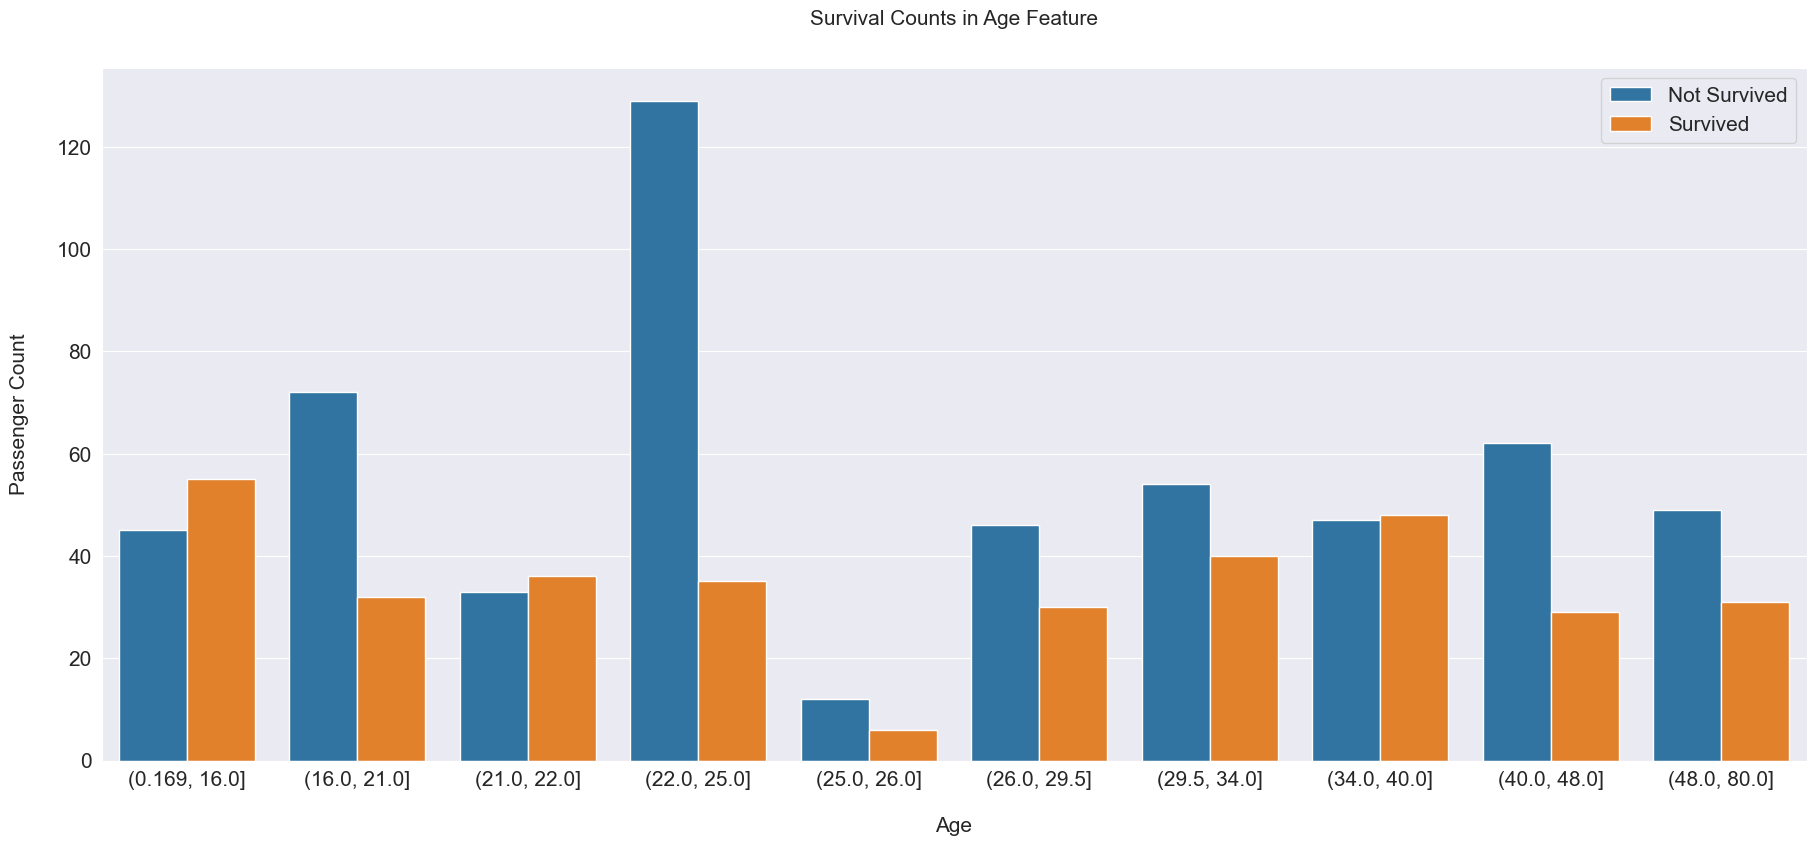

In [39]:
fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(x='Age', hue='Survived', data=df_all)

plt.xlabel('Age', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Survival Counts in {} Feature'.format('Age'), size=15, y=1.05)

가족크기는 SibSp, Parch와 1이 더해져 만들어진 피쳐이다. SibSp는 형제자매와 배우자의 수이고, Parch는 부모님과 자식의 수이다. 이 피쳐들은 가족의 총 크기를 찾기 위해 더해졌다. 맨 끝에 1을 더하는것은 현재 승객을 의미한다. 그래프들은 가족의 크기가 생존율의 예측자라는 것을 분명하게 보여준다. 왜냐하면 다른 값들은 다른 생존율을 가지고 있기 때문이다.

* 1명은 `Alone`으로 라벨링 했다.
* 2, 3, 4명은 `Small`로 라벨링 했다.
* 5, 6명은 `Medium`으로 라벨링 했다.
* 7, 8, 11명은 `Large`로 라벨링 했다.

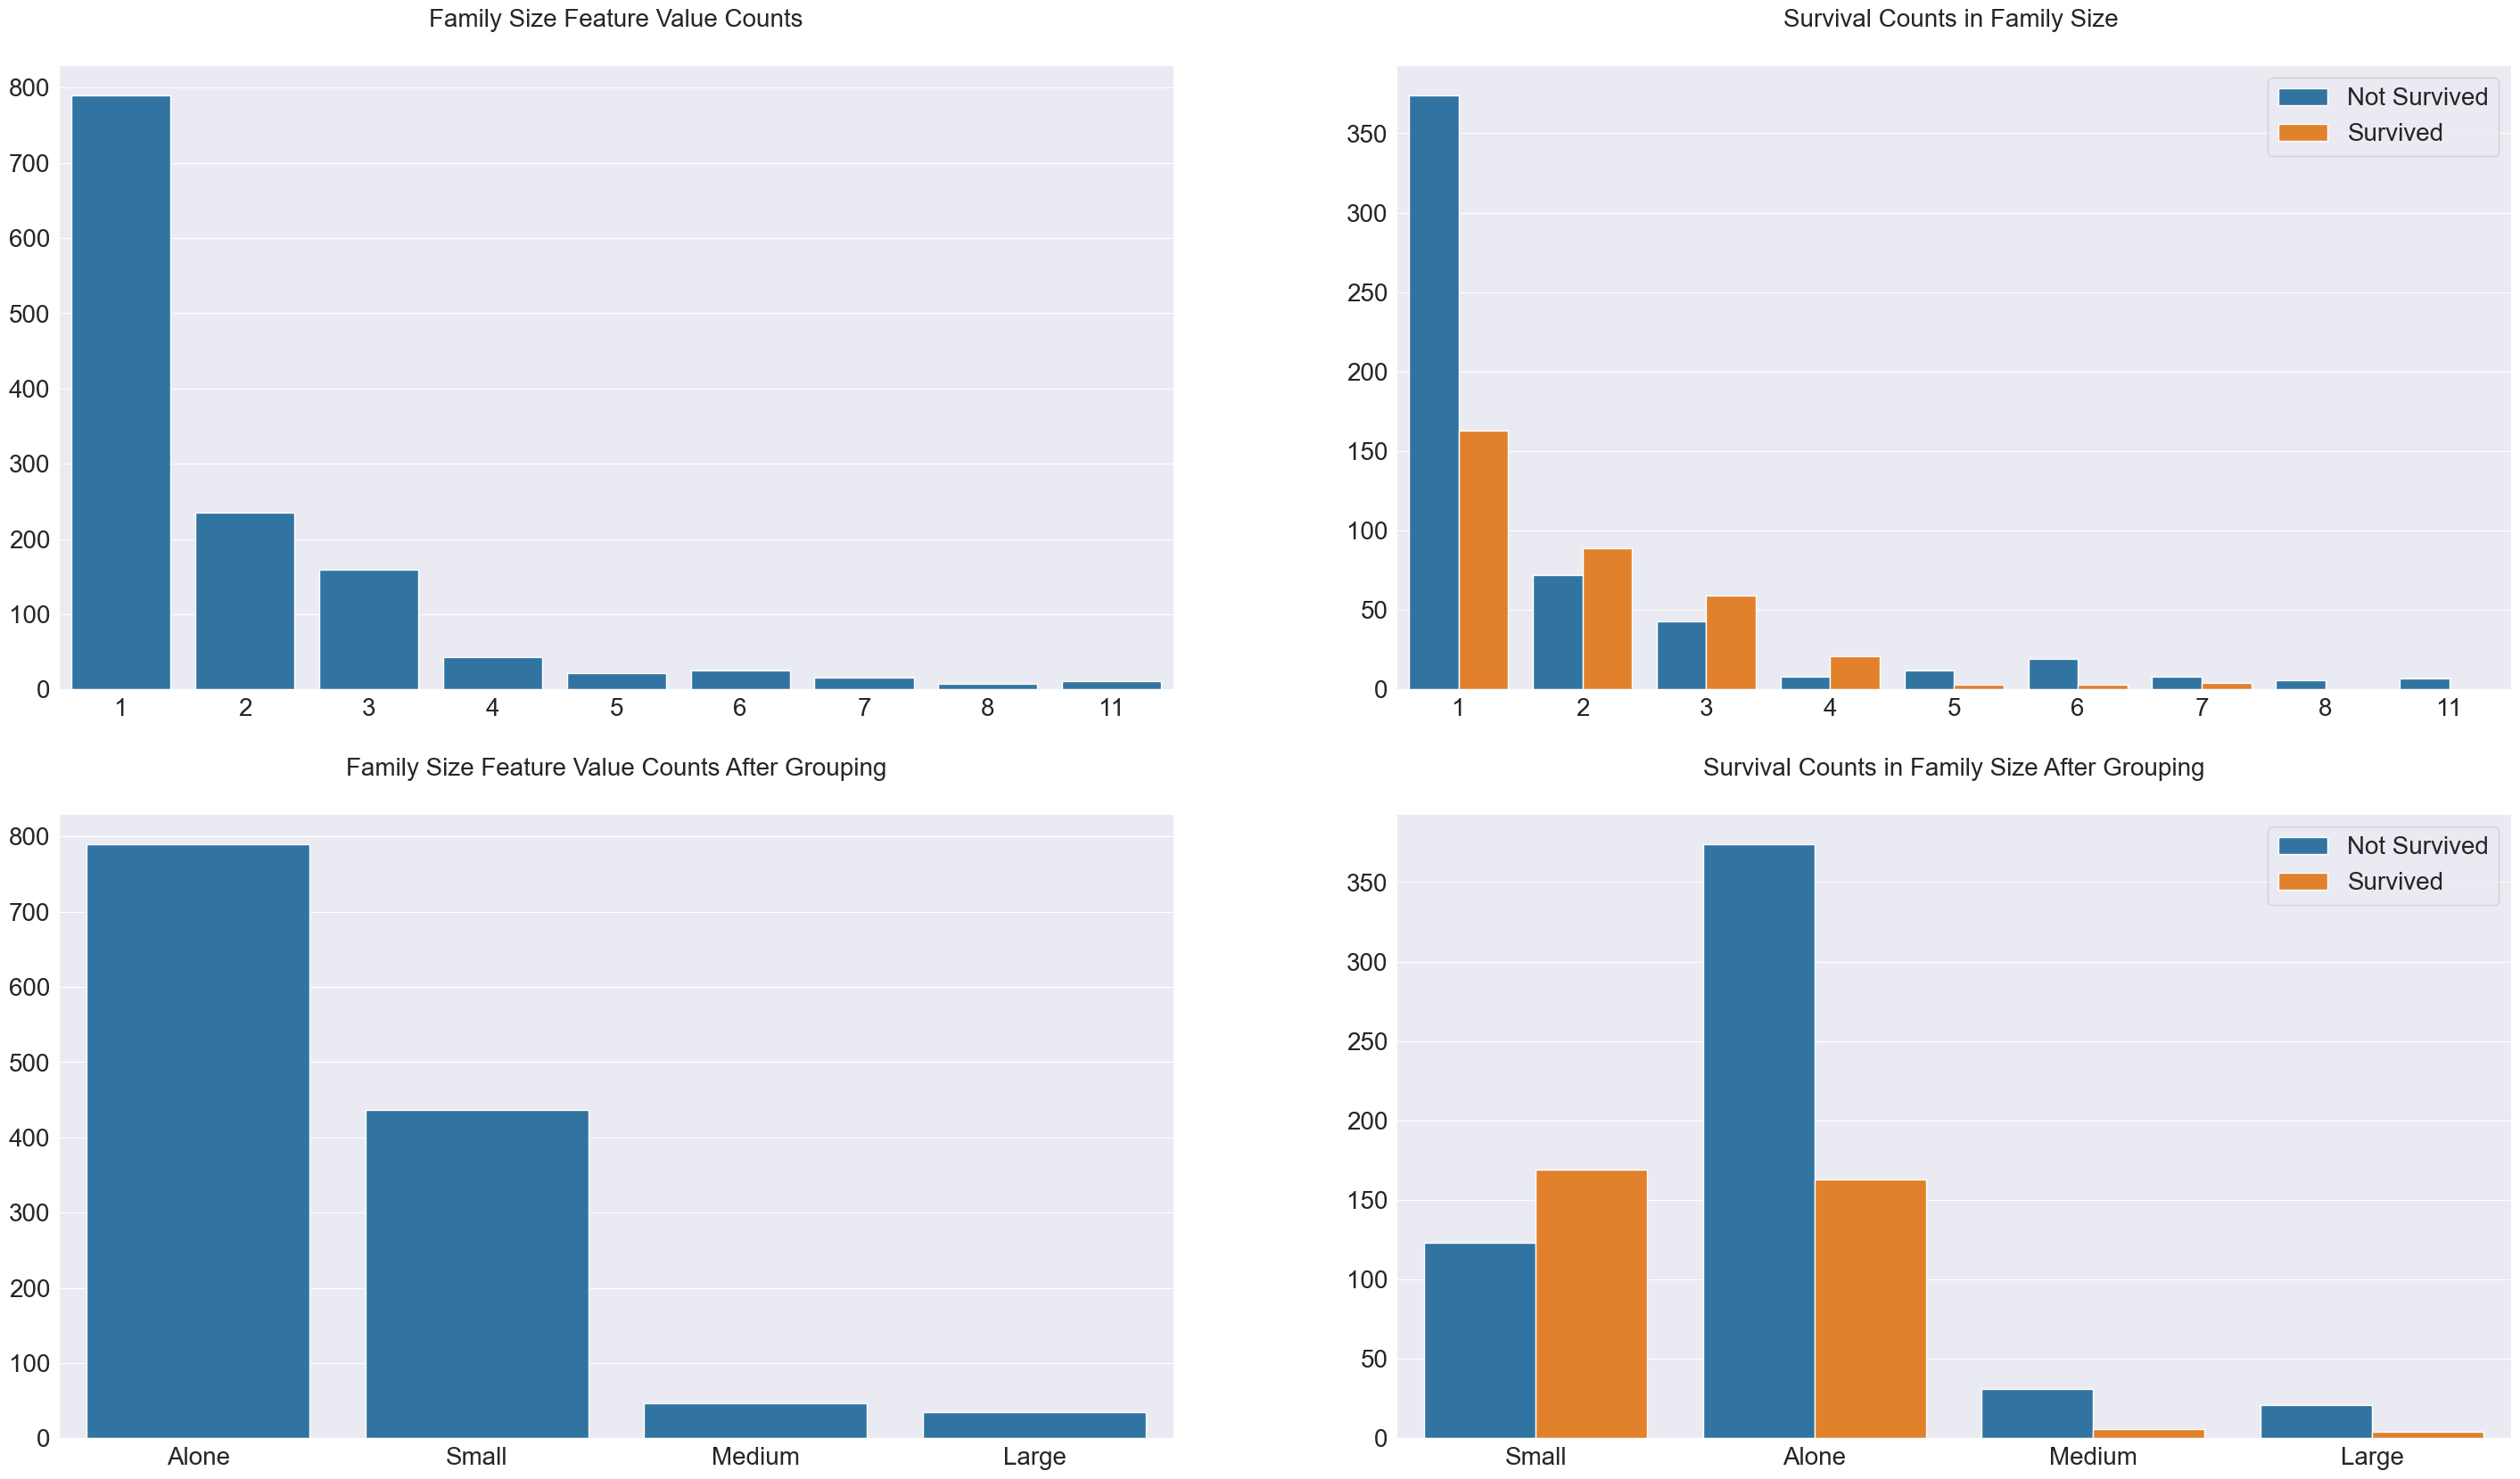

In [40]:
df_all['Family_Size'] = df_all['SibSp'] + df_all['Parch'] + 1

fig, axs = plt.subplots(figsize=(20, 20), ncols=2, nrows=2)
plt.subplots_adjust(right=1.5)

sns.barplot(x=df_all['Family_Size'].value_counts().index, y=df_all['Family_Size'].value_counts().values, ax=axs[0][0])
sns.countplot(x='Family_Size', hue='Survived', data=df_all, ax=axs[0][1])

axs[0][0].set_title('Family Size Feature Value Counts', size=20, y=1.05)
axs[0][1].set_title('Survival Counts in Family Size ', size=20, y=1.05)

family_map = {1: 'Alone', 2: 'Small', 3: 'Small', 4: 'Small', 5: 'Medium', 6: 'Medium', 7: 'Large', 8: 'Large', 11: 'Large'}
df_all['Family_Size_Grouped'] = df_all['Family_Size'].map(family_map)

sns.barplot(x=df_all['Family_Size_Grouped'].value_counts().index, y=df_all['Family_Size_Grouped'].value_counts().values, ax=axs[1][0])
sns.countplot(x='Family_Size_Grouped', hue='Survived', data=df_all, ax=axs[1][1])

axs[1][0].set_title('Family Size Feature Value Counts After Grouping', size=20, y=1.05)
axs[1][1].set_title('Survival Counts in Family Size After Grouping', size=20, y=1.05)

for i in range(2):
    axs[i][1].legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 20})
    for j in range(2):
        axs[i][j].tick_params(axis='x', labelsize=20)
        axs[i][j].tick_params(axis='y', labelsize=20)
        axs[i][j].set_xlabel('')
        axs[i][j].set_ylabel('')


티켓값들은 분석하기에 고유값들이 너무 많다. 그래서 그들의 빈도에 따라 그룹화 하는것이 더 쉽다.

가족 크기 피쳐는 어떻게 티켓 피쳐와 다른가? 많은 승객들이 그룹과 함께 여행했다. 그 그룹들은 친구들, 유모원 교사, 하녀 등으로 구성되어 있었다. 그들은 가족으로 셈되지 않았지만, 같은 티켓을 사용했다.
=> **혼자 했을 때에는 놓친 부분이다.**

호칭에 따른 티켓 그룹화는 왜 안하는가? 만약 호칭이 티켓 피쳐에 의미가 있다면, 그들은 이미 Pclass나 Embarked 피쳐에 포함되어 있을 것이다. 왜냐하면 그것들은 티켓 피쳐에서 유도될 수 있는 유일한 논리적인 정보이기 때문이다.

아래의 그래프를 참조하면, 2, 3, 4명의 그룹은 더 높은 생존율을 가지고 있다. 혼자 여행한 승객들은 가장 낮은 생존율을 가지고 있다. 4명 이상의 그룹은 생존율이 급격히 감소한다. 이 패턴은 Family_Size 피쳐와 매우 유사하지만, 약간의 차이가 있다. Ticket_Frequency 값들은 Family_Size처럼 그룹화 되지 않았다. 왜냐하면 그것은 완벽한 상관관계를 가진 같은 피쳐를 만들 것이기 때문이다. 이런 피쳐는 추가적인 정보를 제공하지 않을 것이다.

In [41]:
df_all['Ticket_Frequency'] = df_all.groupby('Ticket')['Ticket'].transform('count')

Text(0.5, 1.05, 'Count of Survival in Ticket Frequency Feature')

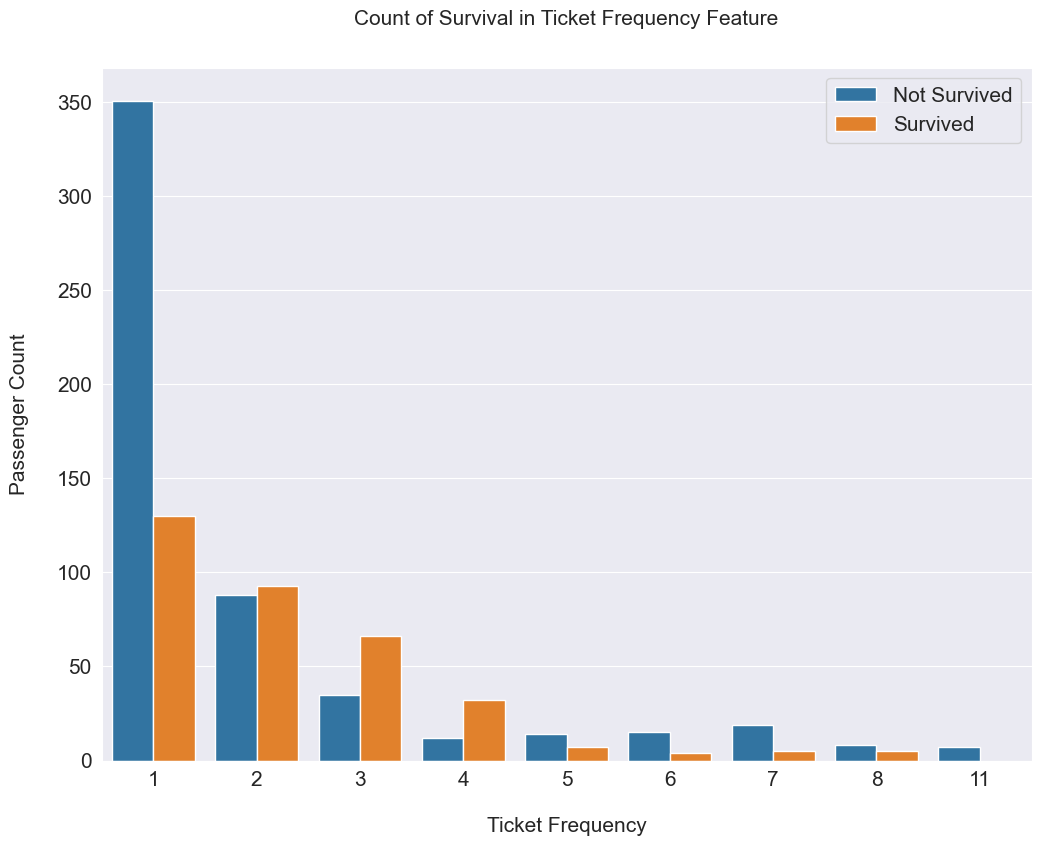

In [42]:
fig, axs = plt.subplots(figsize=(12, 9))
sns.countplot(x='Ticket_Frequency', hue='Survived', data=df_all)

plt.xlabel('Ticket Frequency', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Count of Survival in {} Feature'.format('Ticket Frequency'), size=15, y=1.05)

호칭은 이름에서 앞부분을 따면 된다. 아래의 그래프를 보면, 몇몇 호칭들은 매우 적게 나타난다. 몇몇 호칭들은 올바르지 않아 보이고, 대체되어야 한다. Miss, Mrs, Ms, Mlle, Lady, Mme, the Countess, Dona 호칭들은 모두 여성이기 때문에 Miss/Mrs/Ms로 대체했다. Mlle, Mme, Dona 같은 값들은 사실 승객들의 이름이지만, Name 피쳐가 쉼표로 나눠져 있기 때문에 호칭으로 분류된다. Dr, Col, Major, Jonkheer, Capt, Sir, Don, Rev 호칭들은 Dr/Military/Noble/Clergy로 대체했다. 왜냐하면 그 승객들은 비슷한 특성을 가지고 있기 때문이다. Master는 유일한 호칭이다. 이 호칭은 26살 이하의 남성 승객들에게 주어진다. 그들은 모든 남성들 중에서 가장 높은 생존율을 가지고 있다.

Is_Married는 Mrs 호칭을 기반으로 한 이진 피쳐이다. Mrs 호칭은 다른 여성 호칭들 중에서 가장 높은 생존율을 가지고 있다. 이 호칭은 모든 여성 호칭들과 함께 그룹화 되어야 한다.

In [43]:
df_all['Title'] = df_all['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
df_all['Is_Married'] = 0
df_all['Is_Married'].loc[df_all['Title'] == 'Mrs'] = 1

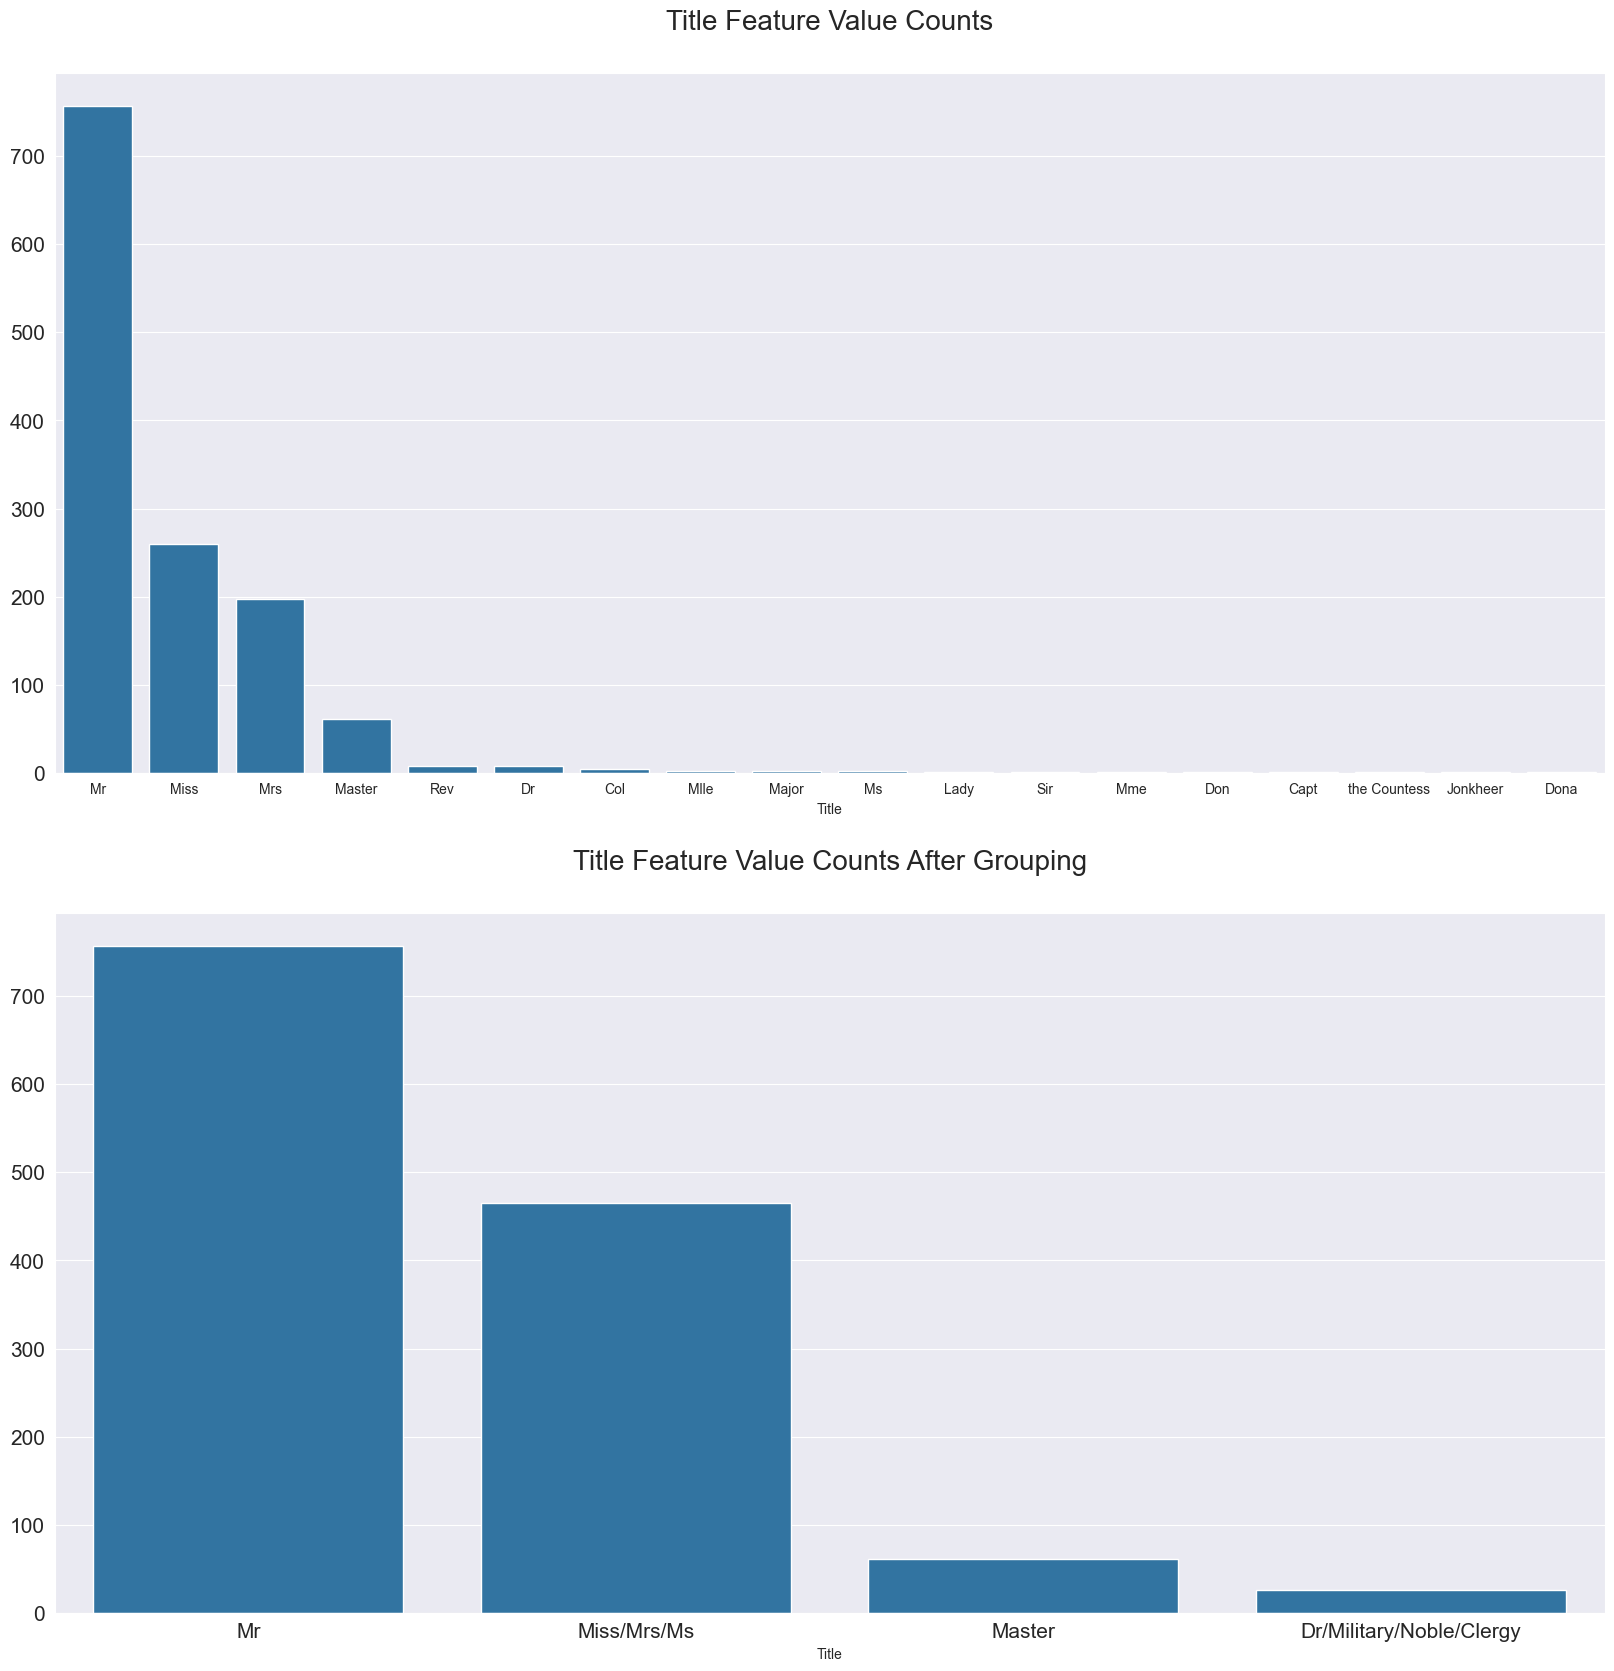

In [44]:
fig, axs = plt.subplots(nrows=2, figsize=(20, 20))
sns.barplot(x=df_all['Title'].value_counts().index, y=df_all['Title'].value_counts().values, ax=axs[0])

axs[0].tick_params(axis='x', labelsize=10)
axs[1].tick_params(axis='x', labelsize=15)

for i in range(2):    
    axs[i].tick_params(axis='y', labelsize=15)

axs[0].set_title('Title Feature Value Counts', size=20, y=1.05)

df_all['Title'] = df_all['Title'].replace(['Miss', 'Mrs','Ms', 'Mlle', 'Lady', 'Mme', 'the Countess', 'Dona'], 'Miss/Mrs/Ms')
df_all['Title'] = df_all['Title'].replace(['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don', 'Rev'], 'Dr/Military/Noble/Clergy')

sns.barplot(x=df_all['Title'].value_counts().index, y=df_all['Title'].value_counts().values, ax=axs[1])
axs[1].set_title('Title Feature Value Counts After Grouping', size=20, y=1.05)

plt.show()

### Target Encoding
extract_surname 함수는 Name 피쳐에서 승객들의 성을 추출하기 위해 사용된다. Family 피쳐는 추출된 성으로 만들어진다. 이것은 같은 가족의 승객들을 그룹화 하는데 필요하다.

In [45]:
import string


def extract_surname(data):    
    
    families = []
    
    for i in range(len(data)):        
        name = data.iloc[i]

        if '(' in name:
            name_no_bracket = name.split('(')[0] 
        else:
            name_no_bracket = name
            
        family = name_no_bracket.split(',')[0]
        title = name_no_bracket.split(',')[1].strip().split(' ')[0]
        
        for c in string.punctuation:
            family = family.replace(c, '').strip()
            
        families.append(family)
            
    return families

df_all['Family'] = extract_surname(df_all['Name'])
df_train = df_all.loc[:890]
df_test = df_all.loc[891:]
dfs = [df_train, df_test]

In [46]:
df_all['Family'].sample(5)

1011          Watt
348         Coutts
212         Perkin
675     Edvardsson
501        Canavan
Name: Family, dtype: object

Family_Survival_Rate는 테스트 셋에 Survived 피쳐가 없기 때문에 트레이닝 셋의 가족들로부터 계산된다. 트레이닝 셋과 테스트 셋에 모두 나타나는 가족들의 리스트(non_unique_families)가 생성된다. 그 리스트에 있는 1명 이상의 가족들에 대한 생존율이 계산되고, Family_Survival_Rate 피쳐에 저장된다.

추가적인 이진 피쳐 Family_Survival_Rate_NA는 테스트 셋에만 나타나는 가족들을 위해 생성된다. 이 피쳐는 가족들의 생존율을 계산할 방법이 없기 때문에 필요하다. 이 피쳐는 가족들의 생존율이 그 승객들에게 적용되지 않는다는 것을 의미한다.

Ticket_Survival_Rate와 Ticket_Survival_Rate_NA 피쳐들은 같은 방법으로 생성된다. Ticket_Survival_Rate와 Family_Survival_Rate는 평균을 내어 Survival_Rate가 되고, Ticket_Survival_Rate_NA와 Family_Survival_Rate_NA는 평균을 내어 Survival_Rate_NA가 된다.

In [50]:
# Creating a list of families and tickets that are occuring in both training and test set
non_unique_families = [x for x in df_train['Family'].unique() if x in df_test['Family'].unique()]
non_unique_tickets = [x for x in df_train['Ticket'].unique() if x in df_test['Ticket'].unique()]

df_family_survival_rate = df_train.groupby('Family')[['Survived', 'Family','Family_Size']].median()
df_ticket_survival_rate = df_train.groupby('Ticket')[['Survived', 'Ticket','Ticket_Frequency']].median()

family_rates = {}
ticket_rates = {}

for i in range(len(df_family_survival_rate)):
    # Checking a family exists in both training and test set, and has members more than 1
    if df_family_survival_rate.index[i] in non_unique_families and df_family_survival_rate.iloc[i, 1] > 1:
        family_rates[df_family_survival_rate.index[i]] = df_family_survival_rate.iloc[i, 0]

for i in range(len(df_ticket_survival_rate)):
    # Checking a ticket exists in both training and test set, and has members more than 1
    if df_ticket_survival_rate.index[i] in non_unique_tickets and df_ticket_survival_rate.iloc[i, 1] > 1:
        ticket_rates[df_ticket_survival_rate.index[i]] = df_ticket_survival_rate.iloc[i, 0]

TypeError: agg function failed [how->mean,dtype->object]

In [ ]:
mean_survival_rate = np.mean(df_train['Survived'])

train_family_survival_rate = []
train_family_survival_rate_NA = []
test_family_survival_rate = []
test_family_survival_rate_NA = []

for i in range(len(df_train)):
    if df_train['Family'][i] in family_rates:
        train_family_survival_rate.append(family_rates[df_train['Family'][i]])
        train_family_survival_rate_NA.append(1)
    else:
        train_family_survival_rate.append(mean_survival_rate)
        train_family_survival_rate_NA.append(0)
        
for i in range(len(df_test)):
    if df_test['Family'].iloc[i] in family_rates:
        test_family_survival_rate.append(family_rates[df_test['Family'].iloc[i]])
        test_family_survival_rate_NA.append(1)
    else:
        test_family_survival_rate.append(mean_survival_rate)
        test_family_survival_rate_NA.append(0)
        
df_train['Family_Survival_Rate'] = train_family_survival_rate
df_train['Family_Survival_Rate_NA'] = train_family_survival_rate_NA
df_test['Family_Survival_Rate'] = test_family_survival_rate
df_test['Family_Survival_Rate_NA'] = test_family_survival_rate_NA

train_ticket_survival_rate = []
train_ticket_survival_rate_NA = []
test_ticket_survival_rate = []
test_ticket_survival_rate_NA = []

for i in range(len(df_train)):
    if df_train['Ticket'][i] in ticket_rates:
        train_ticket_survival_rate.append(ticket_rates[df_train['Ticket'][i]])
        train_ticket_survival_rate_NA.append(1)
    else:
        train_ticket_survival_rate.append(mean_survival_rate)
        train_ticket_survival_rate_NA.append(0)
        
for i in range(len(df_test)):
    if df_test['Ticket'].iloc[i] in ticket_rates:
        test_ticket_survival_rate.append(ticket_rates[df_test['Ticket'].iloc[i]])
        test_ticket_survival_rate_NA.append(1)
    else:
        test_ticket_survival_rate.append(mean_survival_rate)
        test_ticket_survival_rate_NA.append(0)
        
df_train['Ticket_Survival_Rate'] = train_ticket_survival_rate
df_train['Ticket_Survival_Rate_NA'] = train_ticket_survival_rate_NA
df_test['Ticket_Survival_Rate'] = test_ticket_survival_rate
df_test['Ticket_Survival_Rate_NA'] = test_ticket_survival_rate_NA